In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
%matplotlib inline

# EDA

## Long / Short Areas of Interest

In [2]:
long_short_df = pd.read_csv("eye-tracking-dataset-for-the-12-lead-electrocardiogram-interpretation-of-medical-practitioners-and-students-1.0.0/Datasets/Long_Short_Anonymized.csv", index_col=0)
long_short_df

,Study_name,Respondent_Name,Gender,Age,Group,Type,Label,Start,Duration,ParentStimulus,...,TTFF_F,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks
0,ECG Study,Resident,MALE,0,resident,Stimulus,Normal sinus rhythm,178603,30068,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ECG Study,Resident,MALE,0,resident,Static AOI,Short,178603,30068,Normal sinus rhythm,...,265.0,7250.0,24.0,1.0,1.0,41.0,229.0,17.0,32.0,0.0
2,ECG Study,Resident,MALE,0,resident,Static AOI,Long,178603,30068,Normal sinus rhythm,...,15.0,3602.0,12.0,1.0,1.0,19.0,125.0,17.0,29.0,0.0
3,ECG Study,Resident,MALE,0,resident,Stimulus,Atrial fibrillation,309389,30054,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ECG Study,Resident,MALE,0,resident,Static AOI,Short,309389,30054,Atrial fibrillation,...,285.0,4499.0,15.0,1.0,1.0,11.0,130.0,33.0,35.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,Short,99703,30107,ST elevation MI,...,14.0,10372.0,34.0,1.0,1.0,10.0,111.0,34.0,93.0,0.0
1886,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,Long,99703,30107,ST elevation MI,...,2865.0,8118.0,27.0,1.0,1.0,15.0,165.0,17.0,49.0,0.0
1887,ECG Study,Med 2-3,MALE,0,Med 2,Stimulus,Complete heart block,353029,30127,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,Short,353029,30127,Complete heart block,...,429.0,5597.0,19.0,1.0,1.0,13.0,77.0,17.0,73.0,0.0


First row of each study (every 3 rows) contains only important information in label - the real diagnosis that respondents need to find out. That's why it would make sense to create new column for storing this label and delete the rows that contain it.

In [3]:
long_short_labels = long_short_df["Label"].iloc[::3]
long_short_labels = long_short_labels.repeat(2)
new_index = range(len(long_short_labels))
long_short_labels.index = new_index
long_short_labels

0            Normal sinus rhythm
1            Normal sinus rhythm
2            Atrial fibrillation
3            Atrial fibrillation
4                   hyperkalemia
                  ...           
1255    Left bundle branch block
1256             ST elevation MI
1257             ST elevation MI
1258        Complete heart block
1259        Complete heart block
Name: Label, Length: 1260, dtype: object

In [4]:
%%capture --no-display    
long_short_df = long_short_df[long_short_df["Type"] != "Stimulus"]
long_short_df.index = new_index
long_short_df["CorrectLabel"] = long_short_labels
long_short_df

,Study_name,Respondent_Name,Gender,Age,Group,Type,Label,Start,Duration,ParentStimulus,...,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks,CorrectLabel
0,ECG Study,Resident,MALE,0,resident,Static AOI,Short,178603,30068,Normal sinus rhythm,...,7250.0,24.0,1.0,1.0,41.0,229.0,17.0,32.0,0.0,Normal sinus rhythm
1,ECG Study,Resident,MALE,0,resident,Static AOI,Long,178603,30068,Normal sinus rhythm,...,3602.0,12.0,1.0,1.0,19.0,125.0,17.0,29.0,0.0,Normal sinus rhythm
2,ECG Study,Resident,MALE,0,resident,Static AOI,Short,309389,30054,Atrial fibrillation,...,4499.0,15.0,1.0,1.0,11.0,130.0,33.0,35.0,0.0,Atrial fibrillation
3,ECG Study,Resident,MALE,0,resident,Static AOI,Long,309389,30054,Atrial fibrillation,...,6603.0,22.0,1.0,1.0,47.0,218.0,17.0,30.0,0.0,Atrial fibrillation
4,ECG Study,Resident,MALE,0,resident,Static AOI,Short,72977,30080,hyperkalemia,...,8230.0,27.0,1.0,1.0,25.0,212.0,33.0,39.0,0.0,hyperkalemia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,Long,232851,30114,Left bundle branch block,...,6239.0,21.0,1.0,1.0,20.0,158.0,86.0,39.0,0.0,Left bundle branch block
1256,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,Short,99703,30107,ST elevation MI,...,10372.0,34.0,1.0,1.0,10.0,111.0,34.0,93.0,0.0,ST elevation MI
1257,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,Long,99703,30107,ST elevation MI,...,8118.0,27.0,1.0,1.0,15.0,165.0,17.0,49.0,0.0,ST elevation MI
1258,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,Short,353029,30127,Complete heart block,...,5597.0,19.0,1.0,1.0,13.0,77.0,17.0,73.0,0.0,Complete heart block


In [5]:
long_short_df[long_short_df["ParentStimulus"] != long_short_df["CorrectLabel"]]

,Study_name,Respondent_Name,Gender,Age,Group,Type,Label,Start,Duration,ParentStimulus,...,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks,CorrectLabel


We can see that every participant has correctly distinguished the diagnosis, so our study will focus on different ways of how different groups managed to do this.

### Groups Representation in Dataset

In [6]:
long_short_groups = long_short_df.groupby("Group").size()
long_short_groups

Group
CCU Nurse          60
Cathlab Nurse     120
Consultant        180
Fellow            200
General Doctor     40
Med 1             100
Med 2             220
Nurse             120
Technician        200
resident           20
dtype: int64

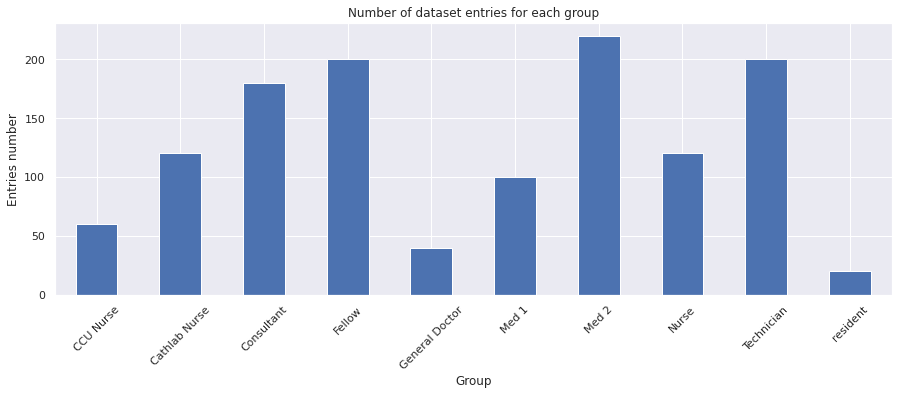

In [7]:
sns.set(rc={'figure.figsize': (15, 5)})
fig = plt.figure()
g = long_short_groups.plot.bar()
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_title(f"Number of dataset entries for each group")
g.set_ylabel("Entries number")
plt.show()

The dataset is quite unbalanced: there are very few entries with residents or general doctors, but much more with senior medical students.

Of course for different areas of interest and maybe for different diagnosises eye tracking parameters will be different, but let's take a look at the most obvious guess at first: what is difference between avarage parameters between different groups of medical practitioners?

In [8]:
long_short_group_av = long_short_df.groupby("Group").mean()
long_short_group_av.reset_index(inplace=True)
long_short_group_av

,Group,Age,Start,Duration,Parent_Stimulus_Start,Parent_Stimulus_Duration,Hit_time_G,Time_spent_G,Time_spent_G_Percentage,Respondent_ratio_G,...,TTFF_F,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks
0,CCU Nurse,10.666667,235133.733333,30143.300000,235133.733333,30143.300000,3156.233333,11870.833333,39.383333,0.983333,...,3460.283333,3832.250000,12.800000,0.950000,0.950000,27.833333,116.683333,42.316667,29.450000,0.033333
1,Cathlab Nurse,0.000000,192102.300000,23464.166667,192102.300000,23464.166667,1333.333333,10937.891667,46.291667,1.000000,...,858.275000,5565.133333,23.125000,0.991667,1.000000,17.325000,101.975000,60.583333,60.808333,0.016667
2,Consultant,9.333333,179119.822222,20295.611111,179119.822222,20295.611111,1651.388889,8622.655556,41.855556,1.000000,...,1307.994444,3683.605556,18.961111,0.961111,1.000000,13.916667,80.027778,57.950000,52.538889,0.038889
3,Fellow,9.700000,176406.880000,24058.870000,176406.880000,24058.870000,1535.000000,10526.760000,43.545000,1.000000,...,1240.670000,5473.545000,23.595000,0.985000,0.995000,14.605000,110.265000,66.870000,53.450000,0.005000
4,General Doctor,0.000000,239883.000000,30153.850000,239883.000000,30153.850000,1843.750000,13434.900000,44.625000,1.000000,...,1032.500000,7567.150000,25.075000,1.000000,1.000000,14.325000,153.350000,87.875000,50.550000,0.325000
5,Med 1,8.000000,211289.760000,29847.380000,211289.760000,29847.380000,1552.500000,12499.910000,41.950000,1.000000,...,1528.950000,5301.370000,17.780000,0.990000,1.000000,22.150000,115.590000,43.790000,42.250000,0.070000
6,Med 2,2.000000,215708.281818,28861.218182,215708.281818,28861.218182,1618.181818,12898.690909,44.863636,1.000000,...,1048.636364,6783.213636,23.945455,0.995455,1.000000,18.772727,119.590909,80.340909,64.522727,0.054545
7,Nurse,0.000000,212582.566667,30078.533333,212582.566667,30078.533333,3964.583333,11547.700000,38.425000,1.000000,...,3489.141667,6326.566667,21.083333,0.941667,0.983333,16.666667,118.783333,53.025000,53.358333,0.058333
8,Technician,0.000000,243576.000000,28719.970000,243576.000000,28719.970000,1675.000000,12637.050000,43.900000,1.000000,...,1312.945000,5648.840000,19.825000,1.000000,1.000000,22.915000,131.270000,55.610000,42.900000,0.020000
9,resident,0.000000,205748.500000,30073.000000,205748.500000,30073.000000,1600.000000,14517.100000,48.400000,1.000000,...,666.150000,5873.100000,19.500000,1.000000,1.000000,25.500000,184.600000,22.650000,31.150000,0.000000


In [9]:
def plot_histogram(df, coly, colx="Group"):
    fig = plt.figure()
    if colx == ["Group", "Label"]:
        g = sns.barplot(data=df, x="Group", y=coly, hue="Label")
    else:
        g = sns.barplot(data=df, x=colx, y=coly)
    g.set_title(f"{coly} by {colx}")
    g.set_xticklabels(g.get_xticklabels(), rotation=45)

In [10]:
def plot_all_cols(df, colx):
    plot_histogram(df, "Parent_Stimulus_Duration", colx)
    plot_histogram(df, "Hit_time_G", colx)
    plot_histogram(df, "Time_spent_G", colx)
    plot_histogram(df, "Time_spent_G_Percentage", colx)
    plot_histogram(df, "Respondent_ratio_G", colx)
    plot_histogram(df, "Revisit_G_Revisitors", colx)
    plot_histogram(df, "Revisit_G_Visitors", colx)
    plot_histogram(df, "Revisit_G_Revisits", colx)
    plot_histogram(df, "TTFF_F", colx)
    plot_histogram(df, "Time_spent_F", colx)
    plot_histogram(df, "Time_spent_F_Percentage", colx)
    plot_histogram(df, "Revisit_F_Revisitors", colx)
    plot_histogram(df, "Revisit_F_Visitors", colx)
    plot_histogram(df, "Revisit_F_Revisits", colx)
    plot_histogram(df, "Fixations_Count", colx)
    plot_histogram(df, "First_Fixation_Duration", colx)
    plot_histogram(df, "Average_Fixations_Duration", colx)
    plot_histogram(df, "Mouse_Clicks", colx)

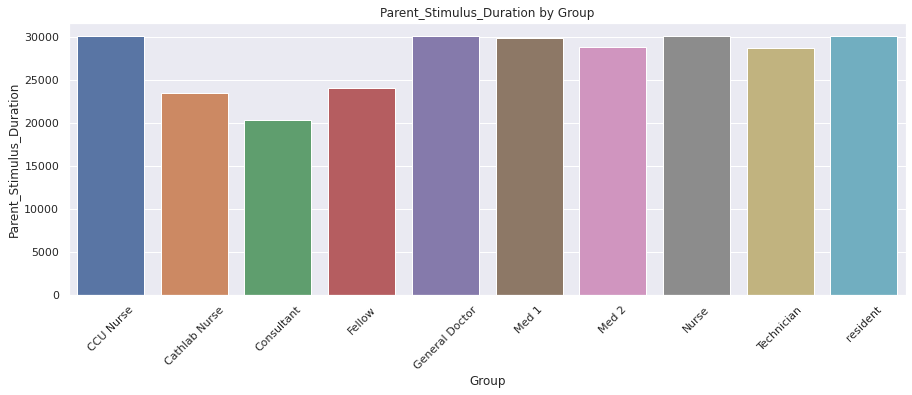

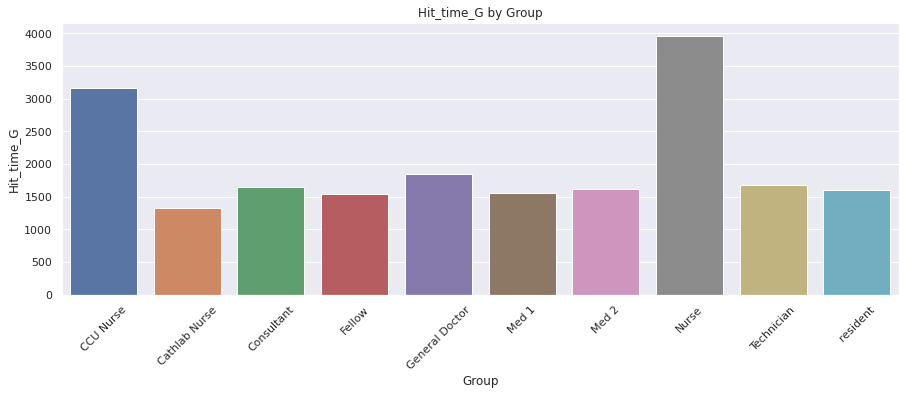

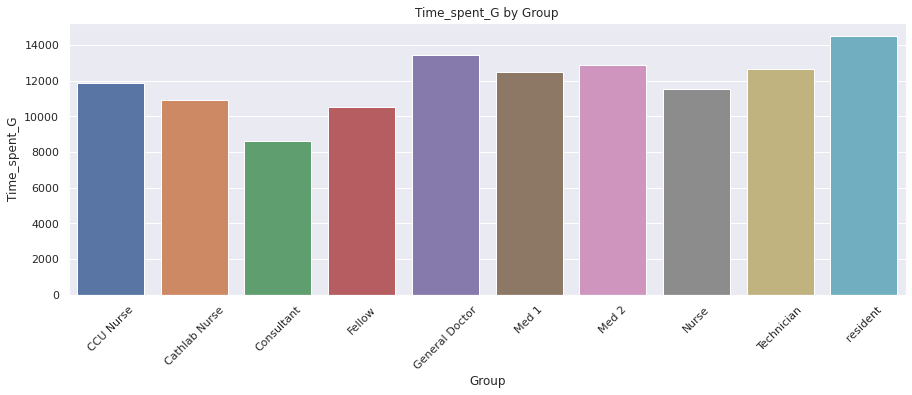

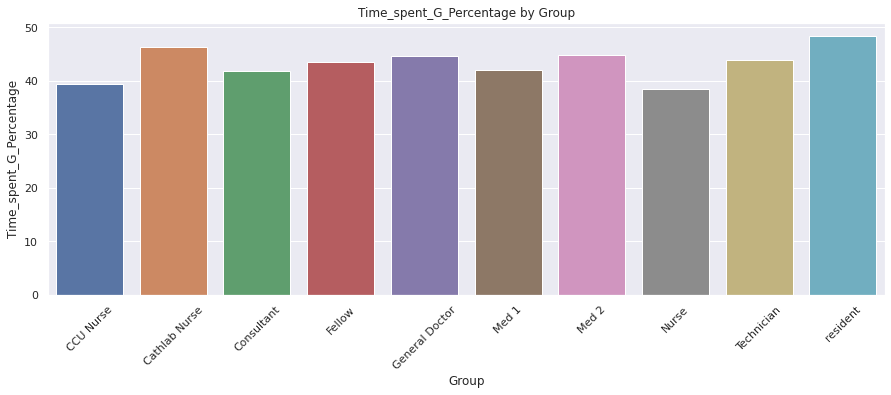

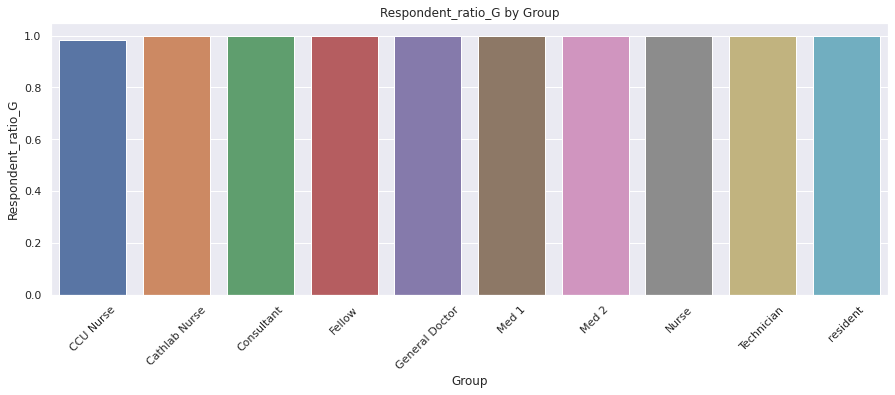

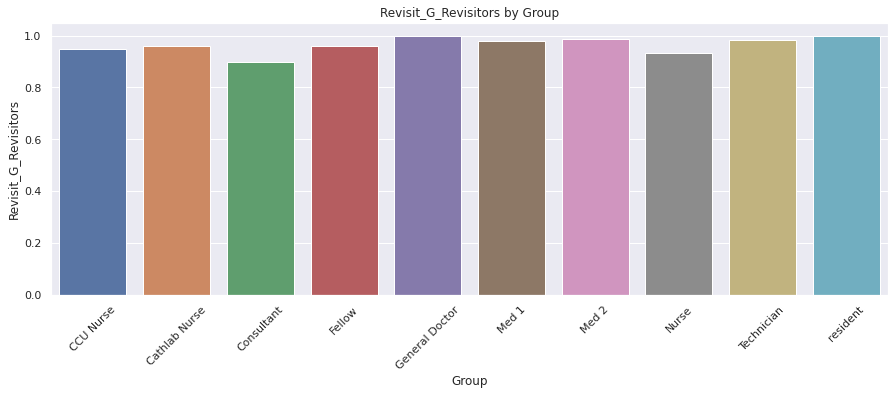

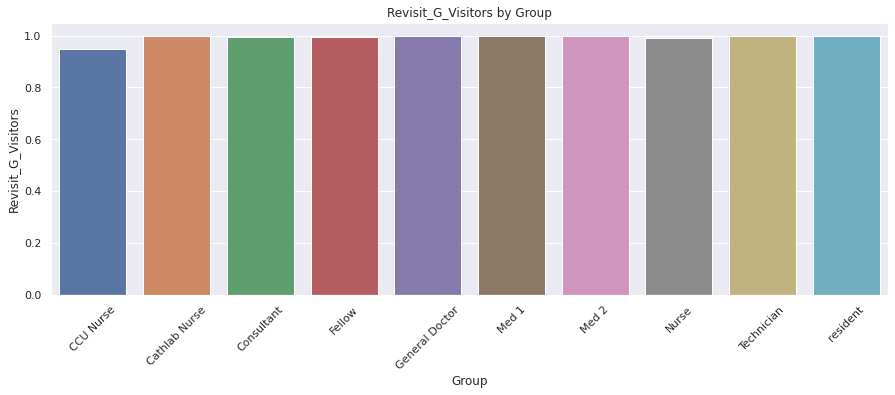

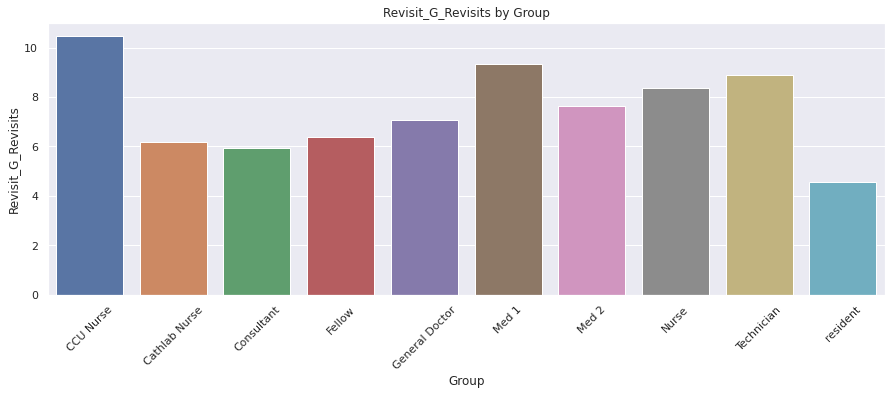

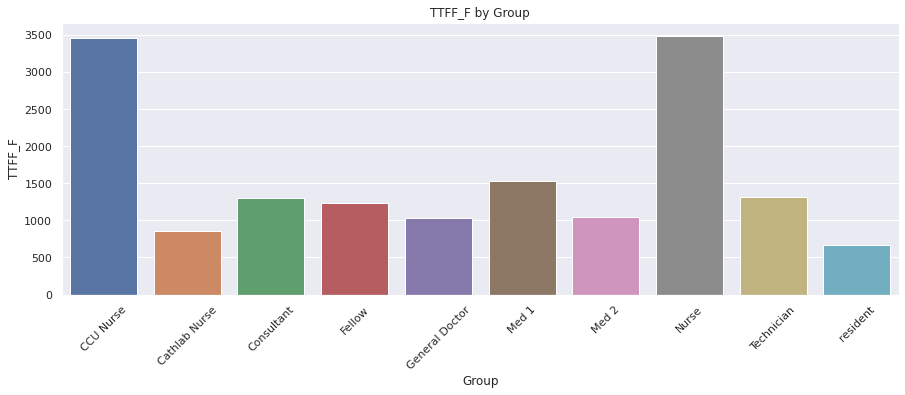

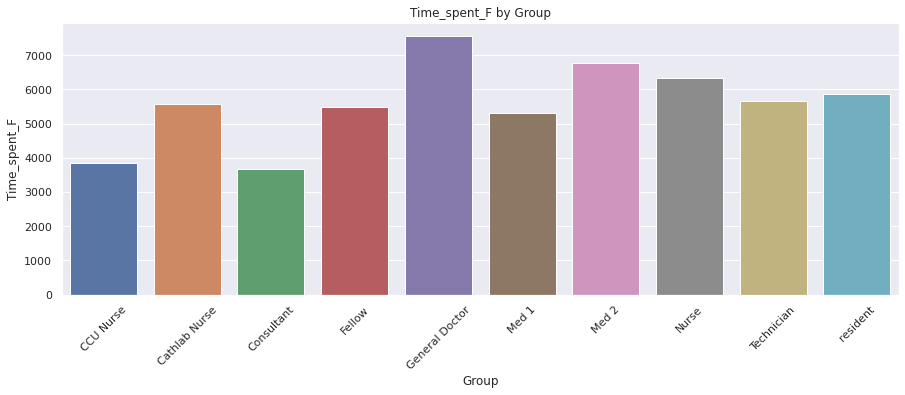

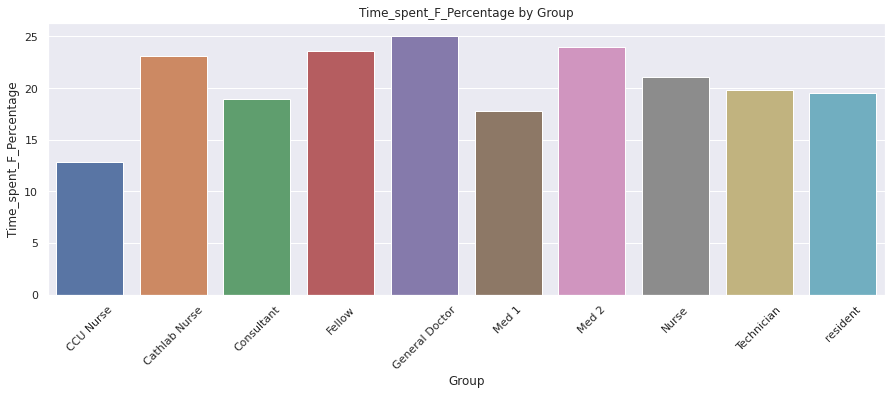

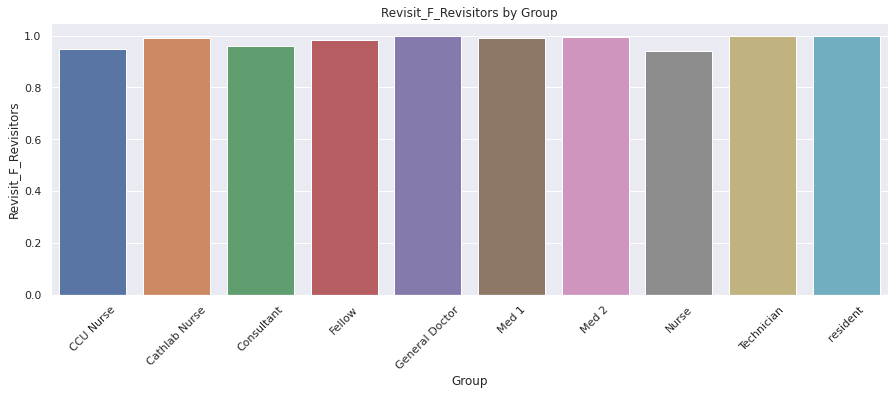

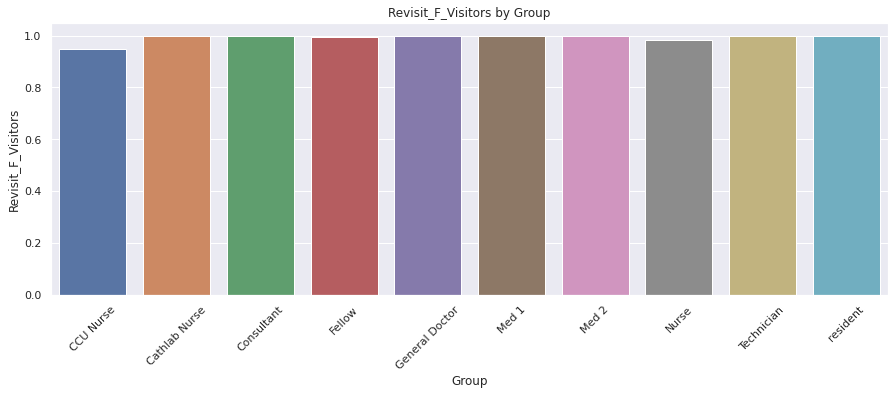

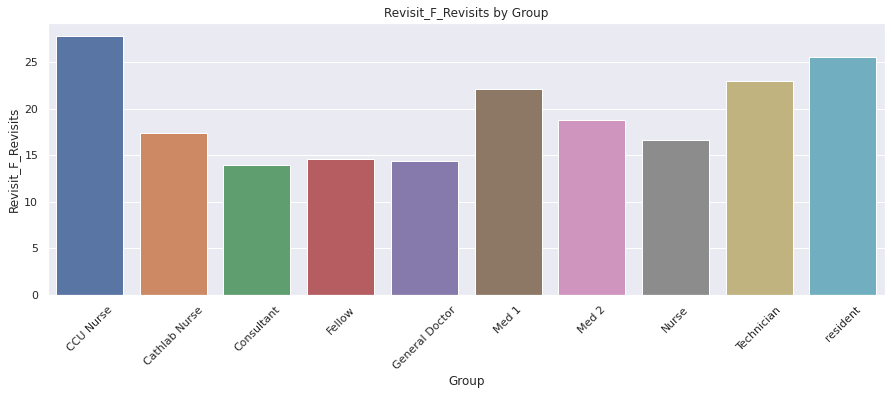

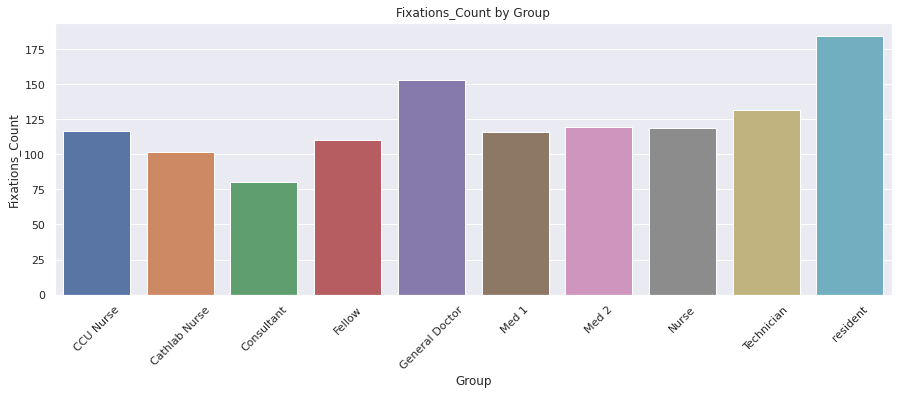

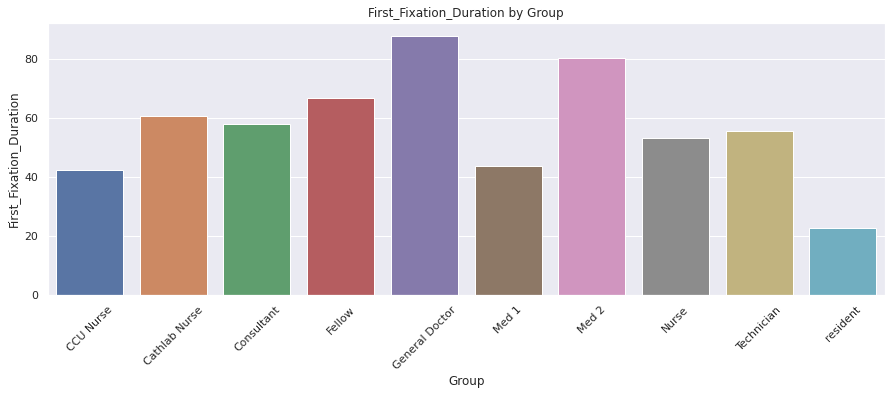

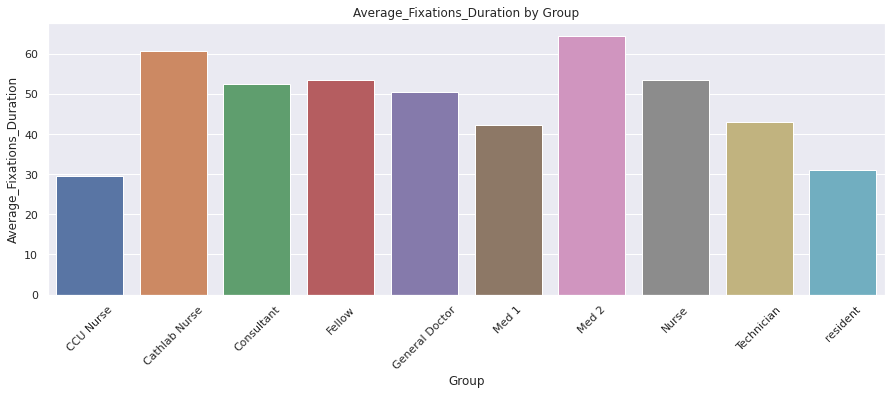

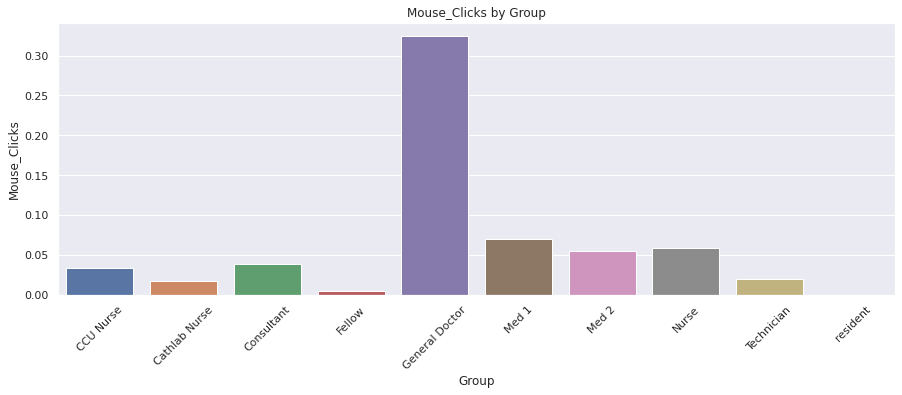

In [11]:
plot_all_cols(long_short_group_av, "Group")

Duration does not differ significantly, as most categories have duration of 30 seconds, even though consultants, cathlab nurses and fellows spend slightly less time (20-25 seconds).

Hit time for gazing is a great parameter, because we can clearly highlight CCU nurse and Nurse, as they have the highest Hit Time G (need approximately twice as much time as other categories).

Time spent gazing differs for some categories, but it is just because of different durations. For time spent gazing in percentage values are approximately the same. CCU nurse and Nurse also have somewhat lower percentage of time spent gazing, the same as for hit time.

Almost all participant looked at the areas of interest (except for very little misses from CCU nurses). That makes Respondent ratio-G parameter useless. So are Revisit-G (Revisitors) and Revisit-G (Visitors). However, Revisit-G (Revisits) gives some insight (becauseprevious 2 parameters were binary, whereas this one is counts). CCU Nurses have the most revisits, while residents have the least revisits.

On similar plots with fixations, however, we see that CCU nurses and residents, as well as technicians and junior year medical students have the highest count of refixations. Junior medical students and technicians also had high count of regazing, so the most interesting case here is residents, who have low regazing count, but high refixations.

Time till first fixation is very similar to time till first gazing, as it takes the most time for CCU nurse and Nurse.

Time spent on fixations, both in miliseconds and percents, is very diverse. We can clearly see the less time for CCU nurses. There is not so much time than by others by junior year medical students, however not as little as by CCU nurses. Cathlab nurses, fellows, and consultants have less time in miliseconds, but it gets normalized in percents. Other categories don't have any significant difference.

Fixation count shows the highest values for residents and general doctors and the lowest value for consultants, which is quite interesting. Other categories are approximately in the same range.

First fixation duration is too diverse across the categories, because it is a very low value (a couple of miliseconds). That's why it's hard to see any pattern here.

Interestingly, CCU Nurses and residents have the smallest average fixations durations, however residents have much more fixations count, meaning that they fixate a lot but for small periods, while CCU Nurses spend more time without fixations at all.

Mouse clicks happen too rarily to make a difference, even though general doctors are leading here.

### Group by Areas of Interest

It is interesting to see whether participants have a different behaviour with different areas of interest.

In [12]:
long_short_aoi_av = long_short_df.groupby("Label").mean()
long_short_aoi_av.reset_index(inplace=True)
long_short_aoi_av

,Label,Age,Start,Duration,Parent_Stimulus_Start,Parent_Stimulus_Duration,Hit_time_G,Time_spent_G,Time_spent_G_Percentage,Respondent_ratio_G,...,TTFF_F,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks
0,Long,4.365079,207304.31746,26654.380952,207304.31746,26654.380952,2680.555556,9020.555556,33.123810,1.000000,...,2504.955556,3593.901587,13.414286,0.973016,0.993651,18.111111,87.761905,55.387302,45.130159,0.031746
1,Short,4.365079,207304.31746,26654.380952,207304.31746,26654.380952,1099.403175,14012.463492,53.177778,0.998413,...,532.642857,7496.665079,28.822222,0.990476,0.996825,18.692063,140.649206,67.026984,58.455556,0.055556


Just by looking at the values we can see the difference: almost all values are higher for short AOI, except for times till gazing/fixation.

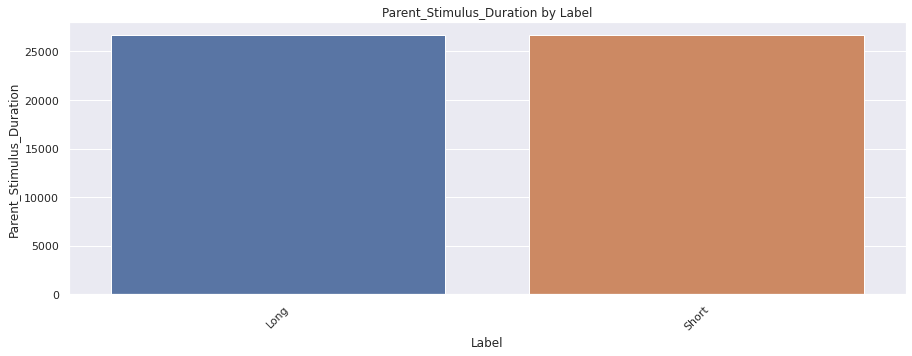

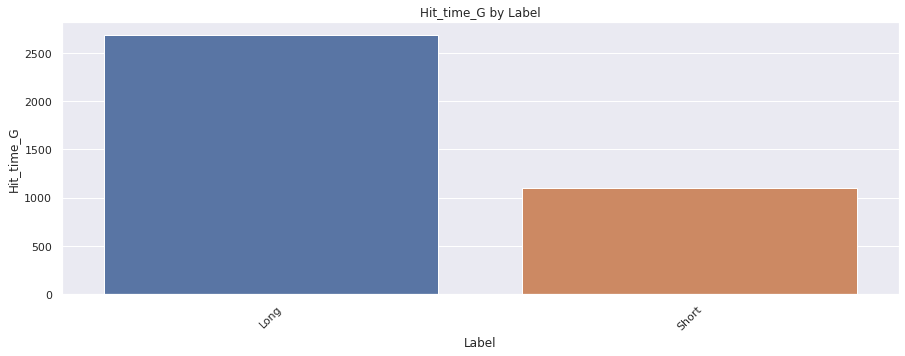

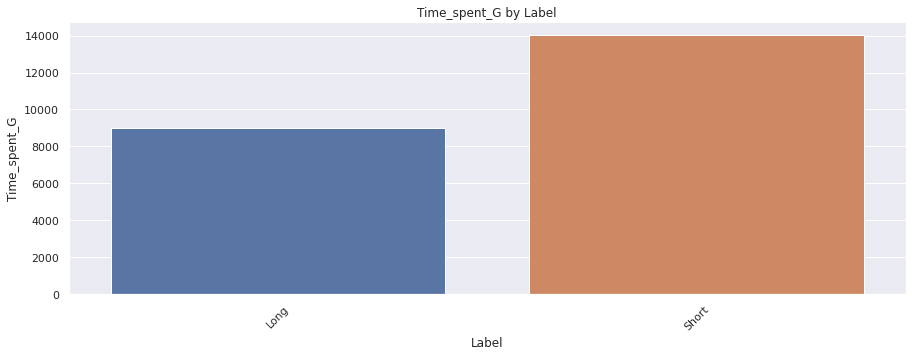

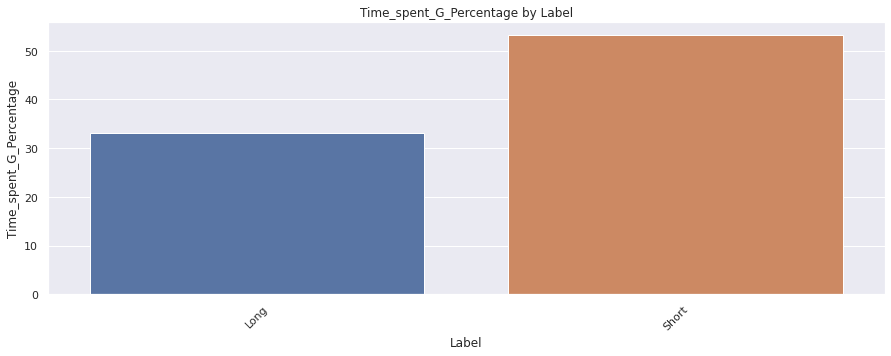

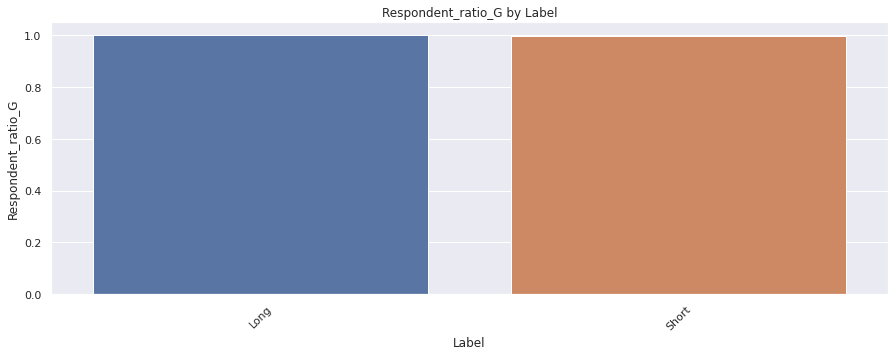

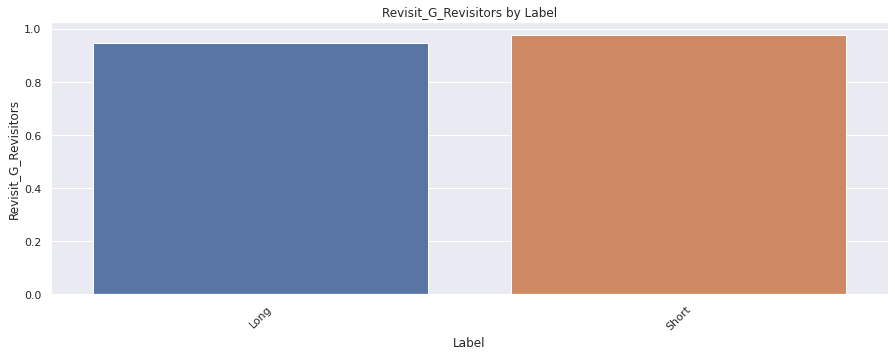

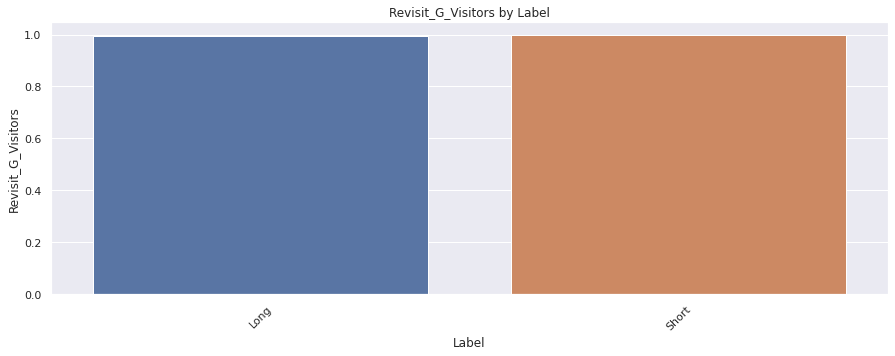

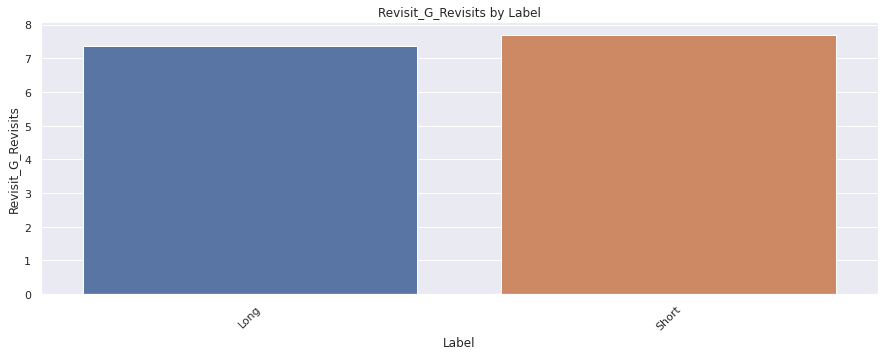

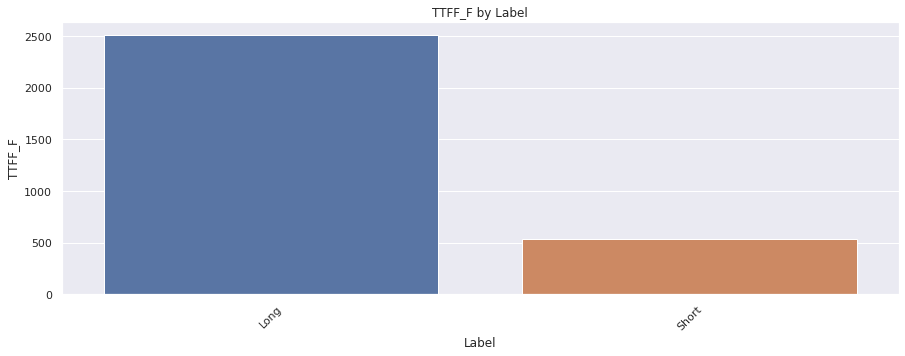

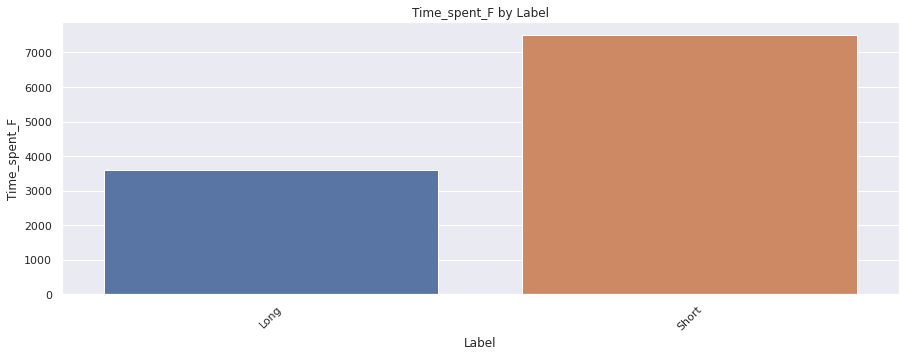

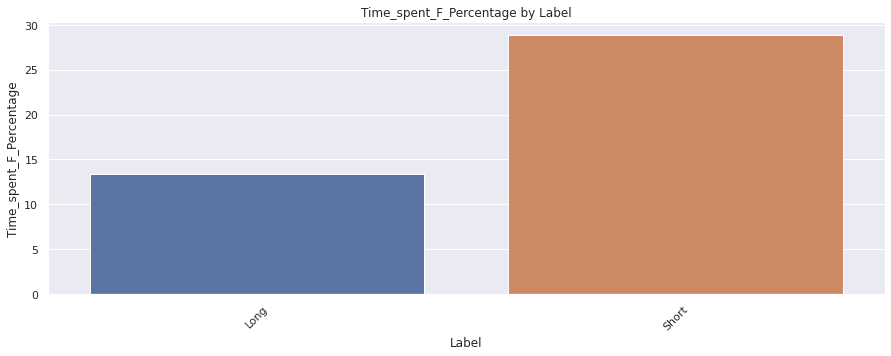

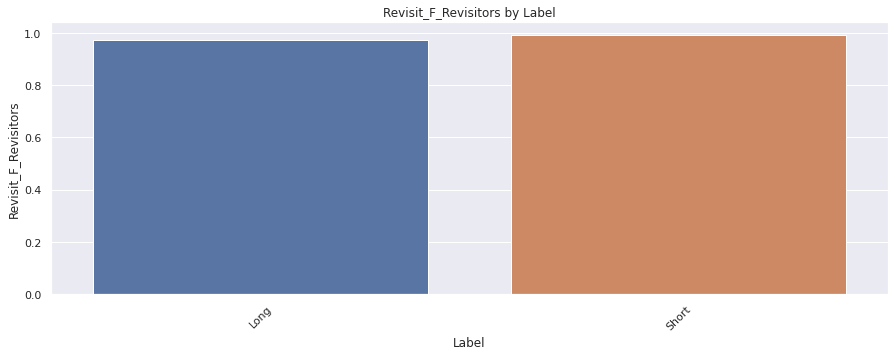

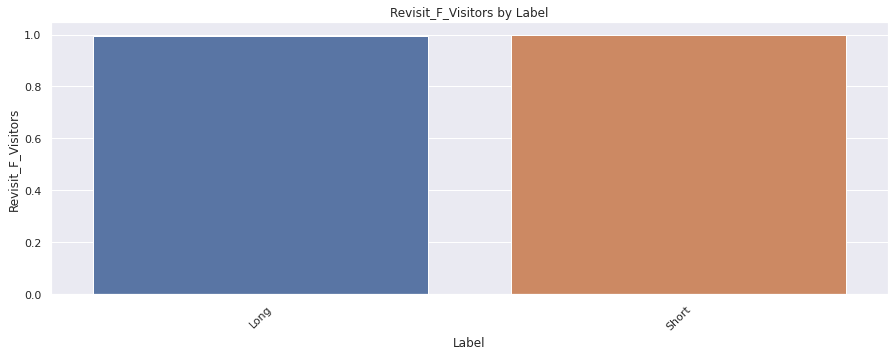

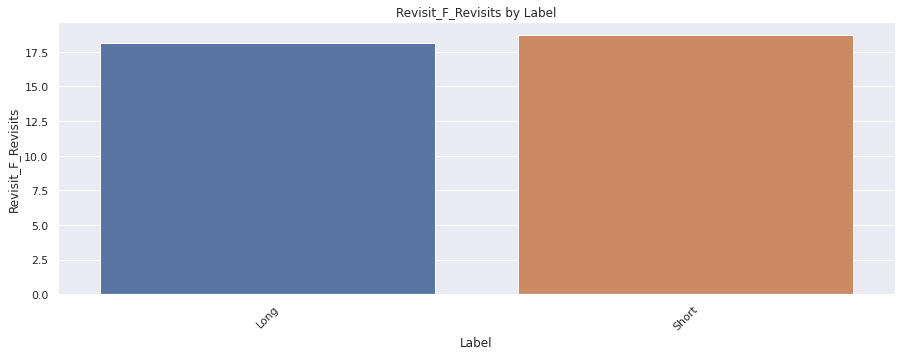

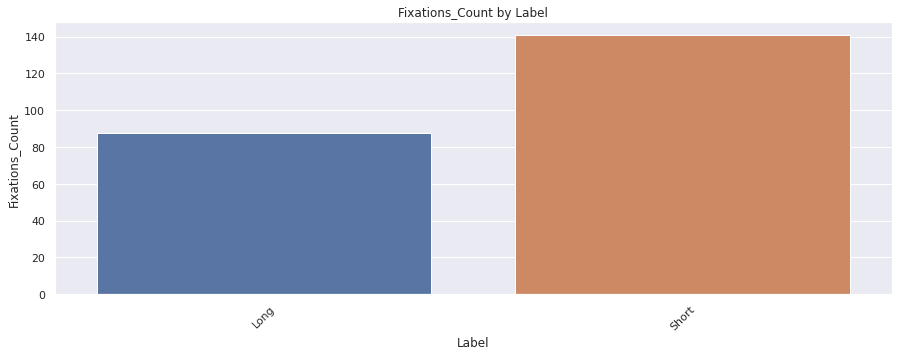

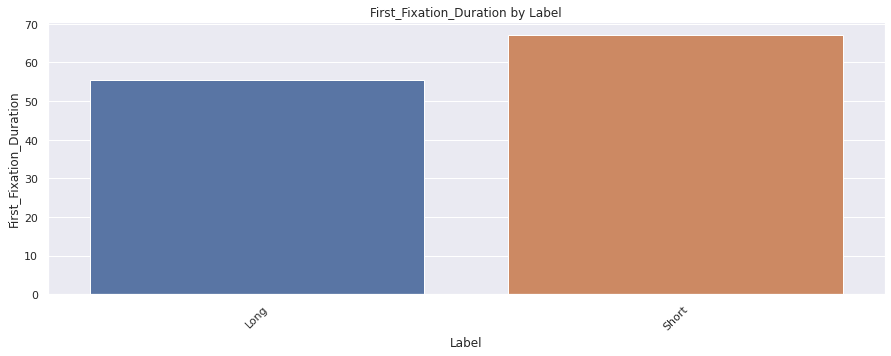

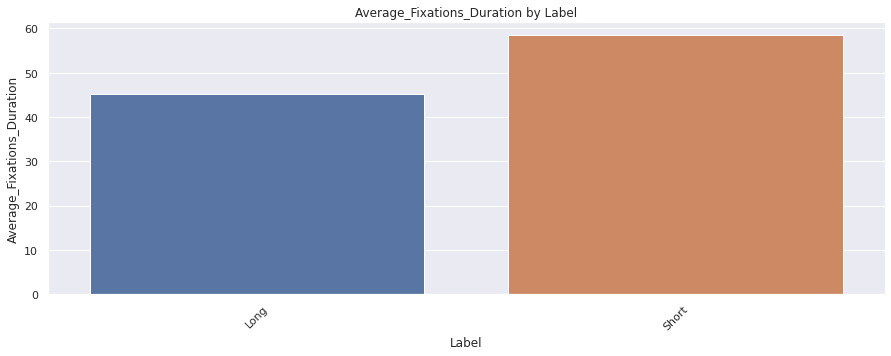

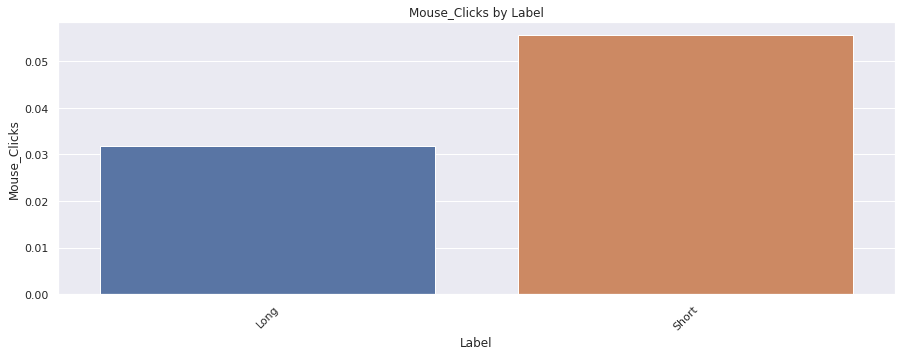

In [13]:
plot_all_cols(long_short_aoi_av, "Label")

In [14]:
long_short_aoi_group_av = long_short_df.groupby(["Label", "Group"]).mean()
long_short_aoi_group_av.reset_index(inplace=True)
long_short_aoi_group_av

,Label,Group,Age,Start,Duration,Parent_Stimulus_Start,Parent_Stimulus_Duration,Hit_time_G,Time_spent_G,Time_spent_G_Percentage,...,TTFF_F,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks
0,Long,CCU Nurse,10.666667,235133.733333,30143.300000,235133.733333,30143.300000,2808.333333,13740.500000,45.600000,...,2584.533333,3253.766667,10.900000,0.966667,0.966667,38.066667,123.166667,42.200000,25.100000,0.000000
1,Long,Cathlab Nurse,0.000000,192102.300000,23464.166667,192102.300000,23464.166667,1450.000000,7610.783333,32.316667,...,1428.116667,3208.916667,13.133333,0.983333,1.000000,16.050000,68.350000,63.633333,54.916667,0.000000
2,Long,Consultant,9.333333,179119.822222,20295.611111,179119.822222,20295.611111,2391.666667,6525.388889,29.977778,...,2168.722222,2295.977778,11.122222,0.955556,1.000000,12.322222,55.311111,62.700000,46.600000,0.011111
3,Long,Fellow,9.700000,176406.880000,24058.870000,176406.880000,24058.870000,2097.500000,6951.060000,28.590000,...,2170.890000,2928.880000,12.800000,0.970000,0.990000,13.210000,72.520000,56.920000,43.500000,0.000000
4,Long,General Doctor,0.000000,239883.000000,30153.850000,239883.000000,30153.850000,2450.000000,11464.650000,38.100000,...,1683.900000,5955.450000,19.750000,1.000000,1.000000,13.550000,142.300000,72.450000,43.600000,0.350000
5,Long,Med 1,8.000000,211289.760000,29847.380000,211289.760000,29847.380000,2635.000000,12441.100000,42.000000,...,2616.040000,4494.900000,15.240000,1.000000,1.000000,23.800000,115.120000,40.080000,35.540000,0.040000
6,Long,Med 2,2.000000,215708.281818,28861.218182,215708.281818,28861.218182,2300.000000,12581.972727,42.927273,...,1799.254545,5776.590909,19.963636,0.990909,1.000000,21.627273,119.981818,64.481818,57.609091,0.054545
7,Long,Nurse,0.000000,212582.566667,30078.533333,212582.566667,30078.533333,6716.666667,6231.466667,20.716667,...,6520.133333,2626.466667,8.800000,0.883333,0.966667,14.016667,67.433333,41.166667,46.133333,0.033333
8,Long,Technician,0.000000,243576.000000,28719.970000,243576.000000,28719.970000,2415.000000,7984.660000,27.630000,...,2386.660000,2927.840000,10.250000,1.000000,1.000000,19.420000,78.560000,52.580000,38.020000,0.020000
9,Long,resident,0.000000,205748.500000,30073.000000,205748.500000,30073.000000,1425.000000,12397.800000,41.400000,...,1035.300000,4483.300000,14.900000,1.000000,1.000000,25.200000,156.200000,20.100000,28.400000,0.000000


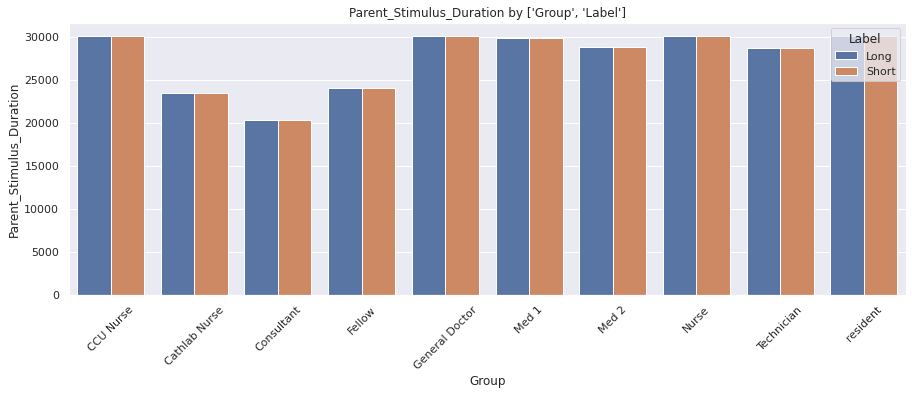

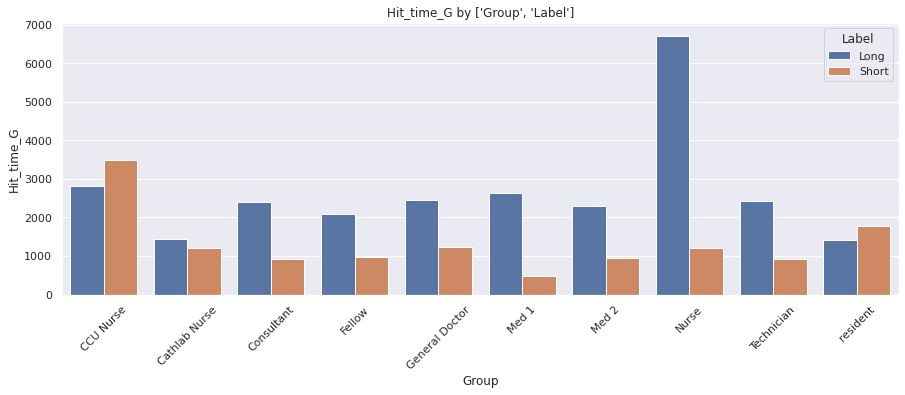

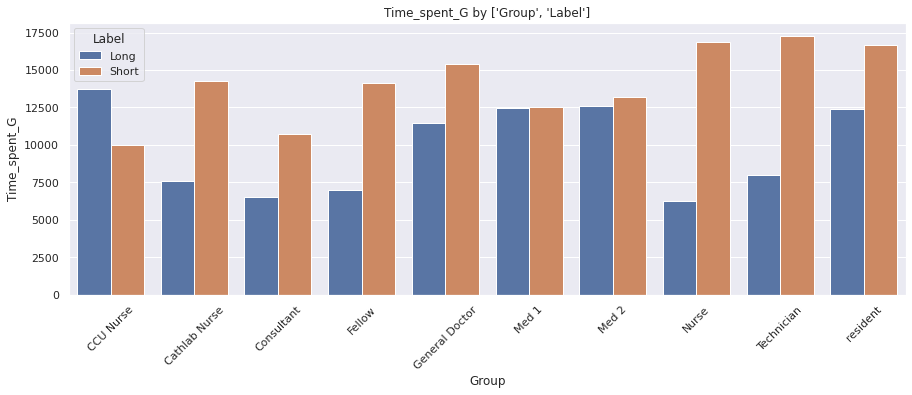

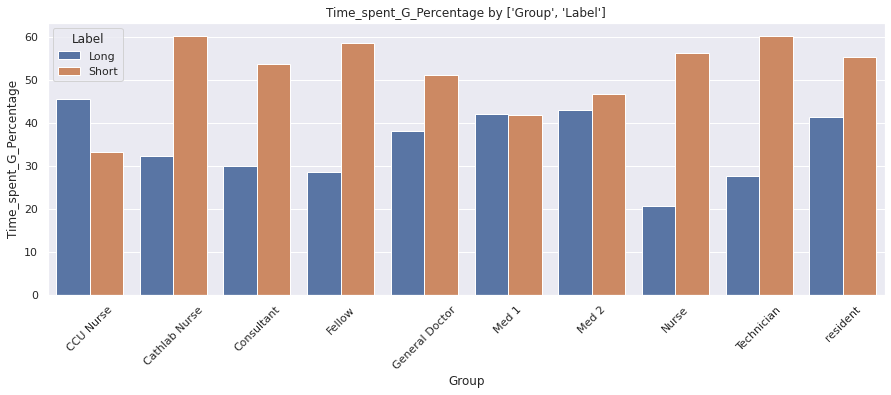

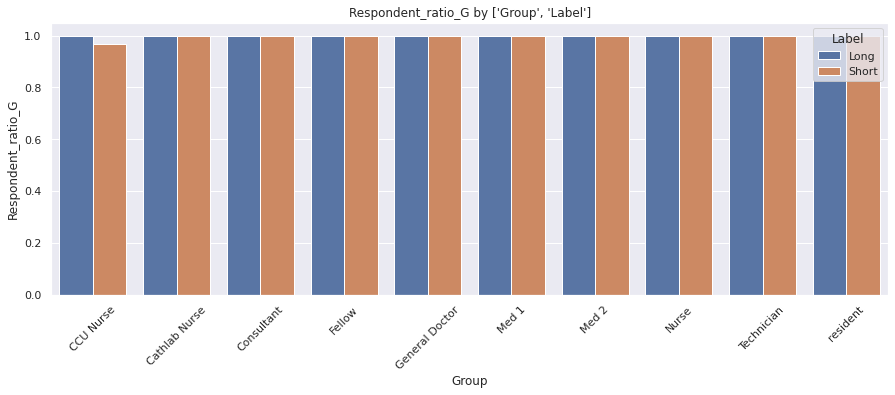

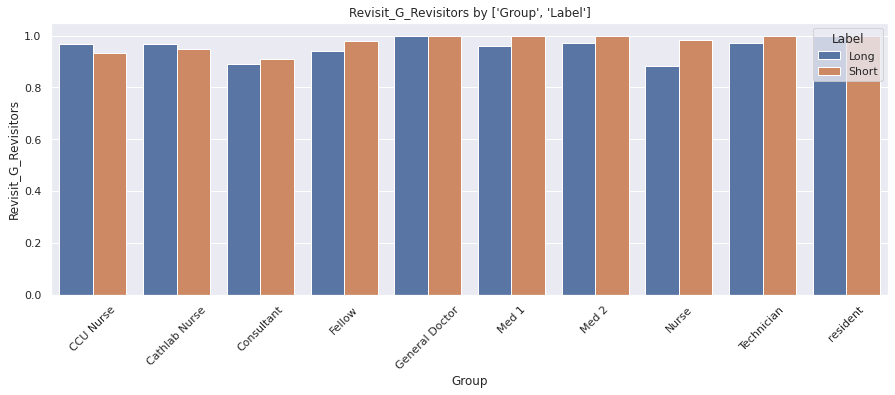

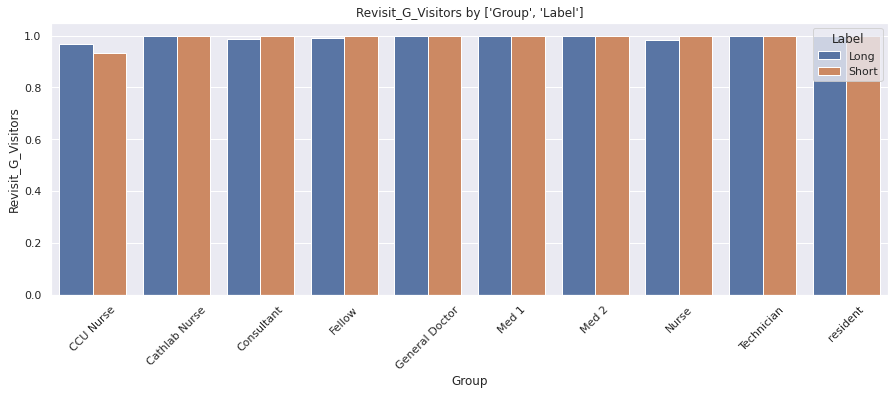

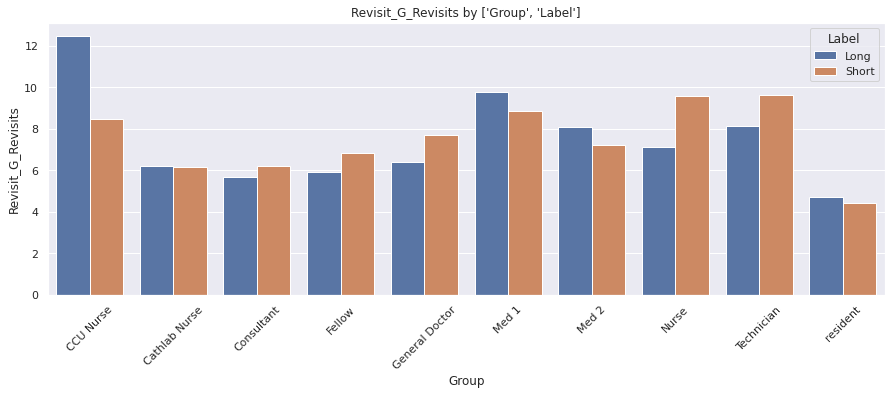

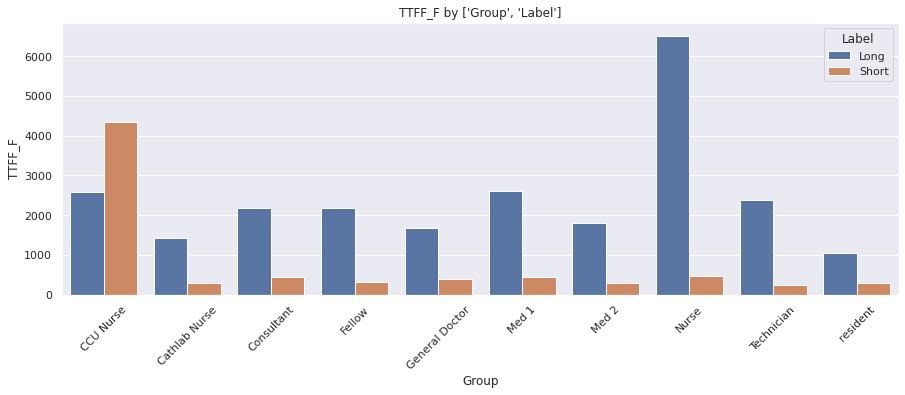

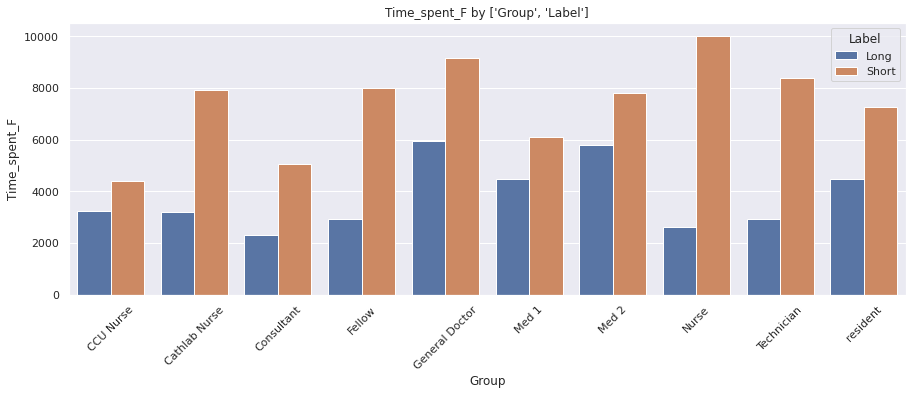

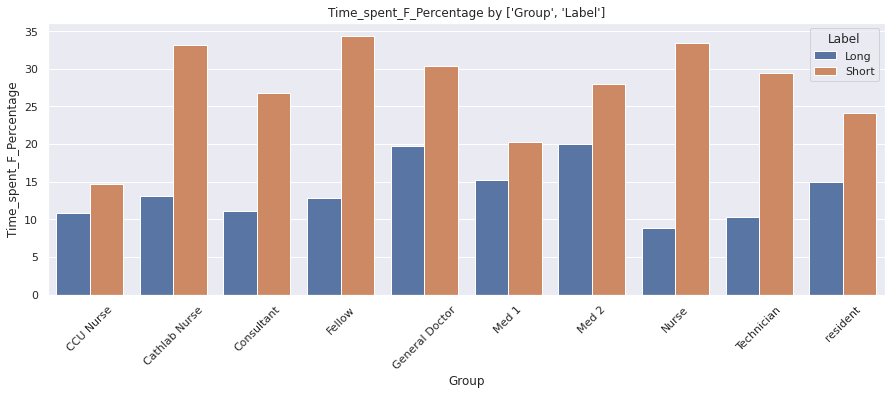

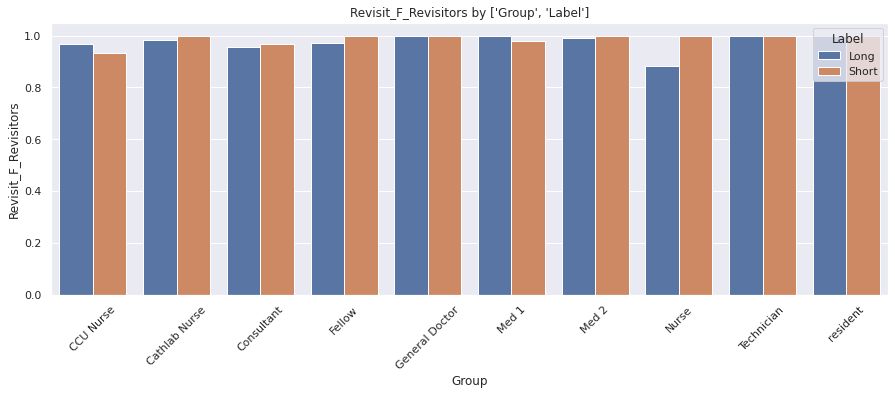

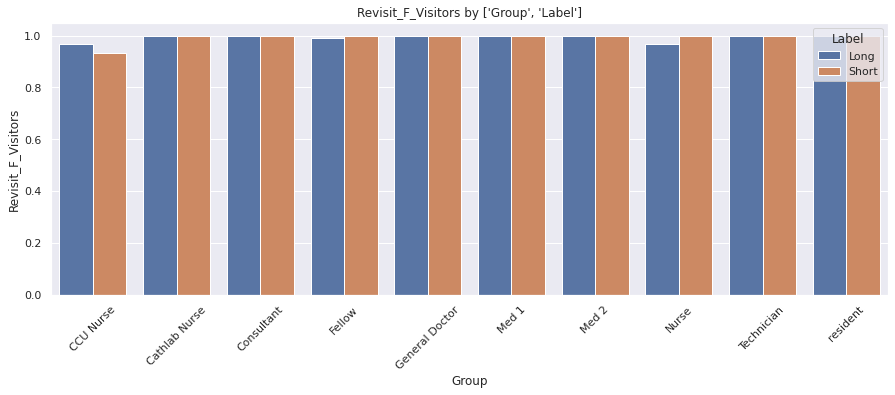

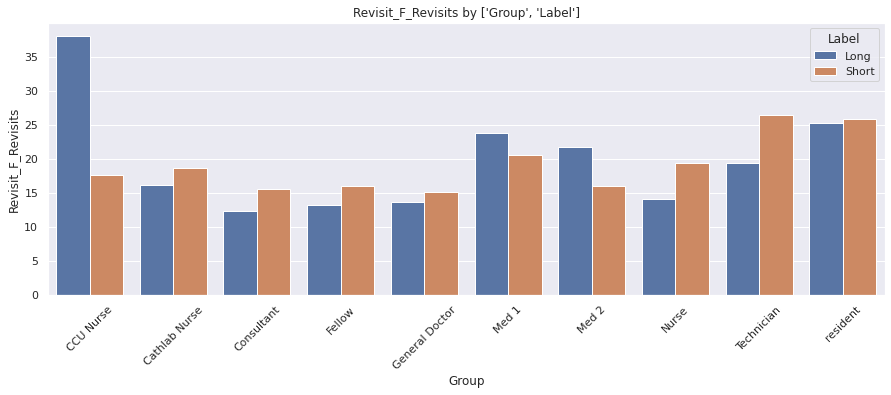

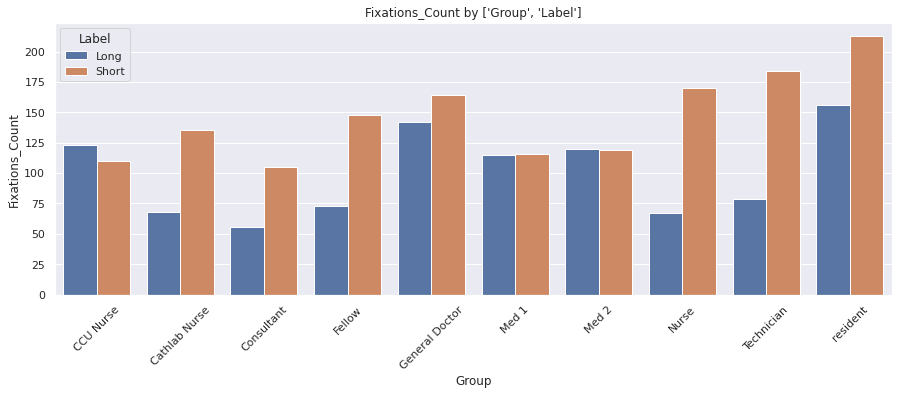

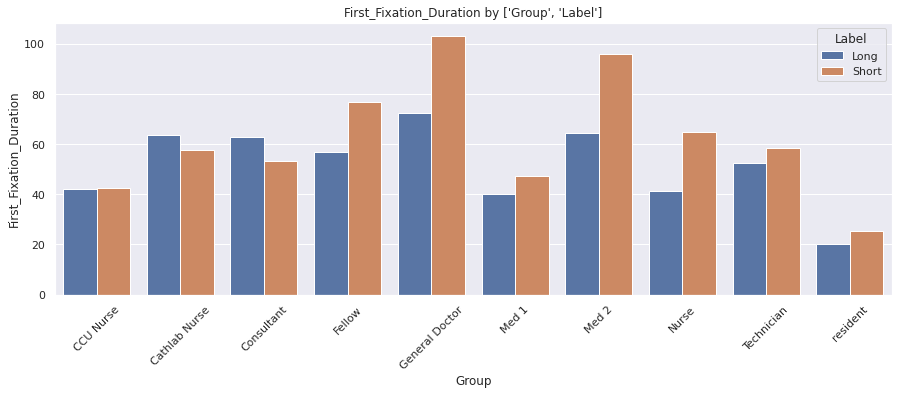

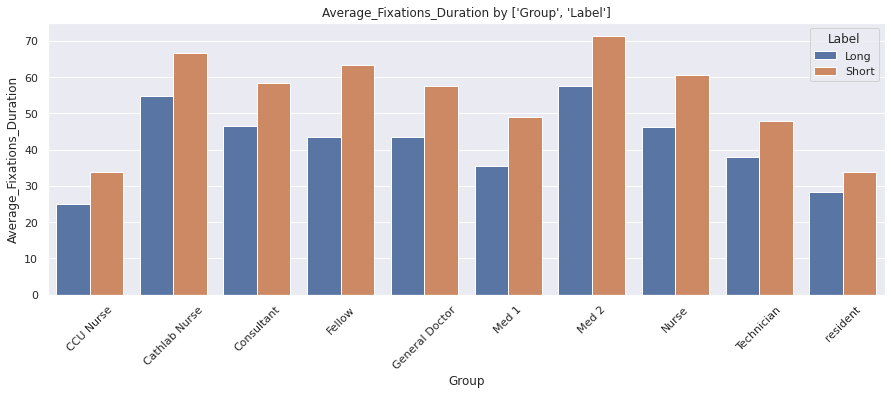

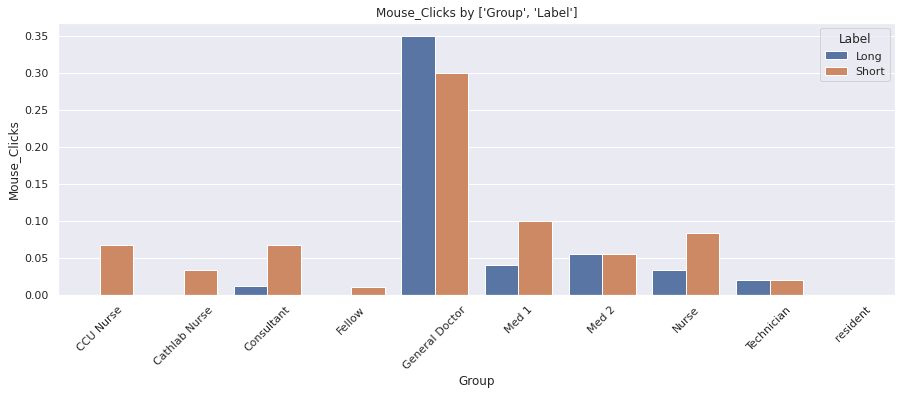

In [15]:
plot_all_cols(long_short_aoi_group_av, ["Group", "Label"])

Time till first gazing / fixation is usually greater for long AOI (except by CCU nurses), but for nurses it is anormally greater (6 or more times larger).

Time spent gazing (both in miliseconds and in percents) is usually greater for short AOI (except by CCU nurses), however for medical students of both year it is approximately the same. For general nurses the difference between short AOI is again 3 times greater than long AOI. Time spent fixating shows similar tendency, but medical students here have longer time with short AOIs.

Fixations count has the same tendency as time spent gazing: usually more for short AOI, except for CCU nurses who have more for long AOI and medical students of both years who have the same count for both long and short AOIs.

Revisits are approximately the same for long/short AOIs, except for CCU nurses, who have more revisits to long AOIs (especially for fixations).

First fixation duration is usually longer for short AOI, but with consultants, cathlab nurses, and CCU nurses it is a bit longer for long AOI. However, this difference is so small that they are almost the same.

Average fixations duration, similarly, is greater for short AOI (always).

Mouse clicks, like with different medical practitioner groups, are unrepresentative.

## Grid Areas of Interest

In [16]:
grid_df = pd.read_csv("eye-tracking-dataset-for-the-12-lead-electrocardiogram-interpretation-of-medical-practitioners-and-students-1.0.0/Datasets/Grid_Anonymized.csv", index_col=0)
grid_df

,Study_name,Respondent_Name,Gender,Age,Group,Type,Label,Start,Duration,ParentStimulus,...,TTFF_F,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks
0,ECG Study,Resident,MALE,0,resident,Stimulus,Normal sinus rhythm,178603,30068,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ECG Study,Resident,MALE,0,resident,Static AOI,V5-1 NSR,178603,30068,Normal sinus rhythm,...,5814.0,150.0,1.0,1.0,1.0,5.0,9.0,17.0,17.0,0.0
2,ECG Study,Resident,MALE,0,resident,Static AOI,II-1 NSR,178603,30068,Normal sinus rhythm,...,6064.0,1050.0,3.0,1.0,1.0,5.0,29.0,34.0,36.0,0.0
3,ECG Study,Resident,MALE,0,resident,Static AOI,V1-1 NSR,178603,30068,Normal sinus rhythm,...,5481.0,133.0,0.0,1.0,1.0,2.0,4.0,33.0,33.0,0.0
4,ECG Study,Resident,MALE,0,resident,Static AOI,1 NSR,178603,30068,Normal sinus rhythm,...,748.0,433.0,1.0,1.0,1.0,6.0,11.0,33.0,39.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15367,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,II-3 CompleteHeartBlock copy copy,353029,30127,Complete heart block,...,27063.0,16.0,0.0,0.0,1.0,0.0,1.0,16.0,16.0,0.0
15368,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,II-4 CompleteHeartBlock copy copy copy,353029,30127,Complete heart block,...,30119.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0
15369,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,V5-2 CompleteHeartBlock,353029,30127,Complete heart block,...,25561.0,349.0,1.0,1.0,1.0,3.0,8.0,16.0,44.0,0.0
15370,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,V5-3 CompleteHeartBlock,353029,30127,Complete heart block,...,26763.0,384.0,1.0,1.0,1.0,3.0,12.0,17.0,32.0,0.0


In [17]:
num_experiments = grid_df["ParentStimulus"].isna().sum()
num_experiments

630

In [18]:
diagnosises_grid = grid_df["ParentStimulus"].fillna(grid_df["Label"])
diagnosises_grid

0         Normal sinus rhythm
1         Normal sinus rhythm
2         Normal sinus rhythm
3         Normal sinus rhythm
4         Normal sinus rhythm
                 ...         
15367    Complete heart block
15368    Complete heart block
15369    Complete heart block
15370    Complete heart block
15371    Complete heart block
Name: ParentStimulus, Length: 15372, dtype: object

In [19]:
def remove_duplicates(lst):
    new_lst = []
    prev_val = None
    for val in lst:
        if val != prev_val:
            new_lst.append(val)
            prev_val = val
    return new_lst
len(remove_duplicates(diagnosises_grid.to_list()))

630

We couldn't appply the method we used for long-short AOIs to find if all participants correctly distinguished diagnosis, because in the grid case there is a different number of areas of interst for each case (probably because not all areas of interest were looked at for some cases). That is why we used a different method here: as all diagnosises are not repeating one by another (all diagnosises are shown to each participant one by one and is written into dataset in this way), we can compare the length of given diagnosises alongside correct diagnosises to number of experiments. As this numbers are the same, we see that participants gave correct diagnosises.

In [20]:
grid_df = grid_df[grid_df["Type"] != "Stimulus"] # remove unneeded rows
grid_df.index = range(len(grid_df))
grid_df

,Study_name,Respondent_Name,Gender,Age,Group,Type,Label,Start,Duration,ParentStimulus,...,TTFF_F,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks
0,ECG Study,Resident,MALE,0,resident,Static AOI,V5-1 NSR,178603,30068,Normal sinus rhythm,...,5814.0,150.0,1.0,1.0,1.0,5.0,9.0,17.0,17.0,0.0
1,ECG Study,Resident,MALE,0,resident,Static AOI,II-1 NSR,178603,30068,Normal sinus rhythm,...,6064.0,1050.0,3.0,1.0,1.0,5.0,29.0,34.0,36.0,0.0
2,ECG Study,Resident,MALE,0,resident,Static AOI,V1-1 NSR,178603,30068,Normal sinus rhythm,...,5481.0,133.0,0.0,1.0,1.0,2.0,4.0,33.0,33.0,0.0
3,ECG Study,Resident,MALE,0,resident,Static AOI,1 NSR,178603,30068,Normal sinus rhythm,...,748.0,433.0,1.0,1.0,1.0,6.0,11.0,33.0,39.0,0.0
4,ECG Study,Resident,MALE,0,resident,Static AOI,aVR NSR,178603,30068,Normal sinus rhythm,...,3498.0,884.0,3.0,1.0,1.0,3.0,20.0,17.0,44.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14737,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,II-3 CompleteHeartBlock copy copy,353029,30127,Complete heart block,...,27063.0,16.0,0.0,0.0,1.0,0.0,1.0,16.0,16.0,0.0
14738,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,II-4 CompleteHeartBlock copy copy copy,353029,30127,Complete heart block,...,30119.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0
14739,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,V5-2 CompleteHeartBlock,353029,30127,Complete heart block,...,25561.0,349.0,1.0,1.0,1.0,3.0,8.0,16.0,44.0,0.0
14740,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,V5-3 CompleteHeartBlock,353029,30127,Complete heart block,...,26763.0,384.0,1.0,1.0,1.0,3.0,12.0,17.0,32.0,0.0


Let's see how different groups of participants differ for grid AOIs. It will be interesting to check for similarities with the same thing for long/short AOIs.

In [21]:
grid_groups = grid_df.groupby("Group").size()
grid_groups

Group
CCU Nurse          702
Cathlab Nurse     1404
Consultant        2106
Fellow            2340
General Doctor     468
Med 1             1170
Med 2             2574
Nurse             1404
Technician        2340
resident           234
dtype: int64

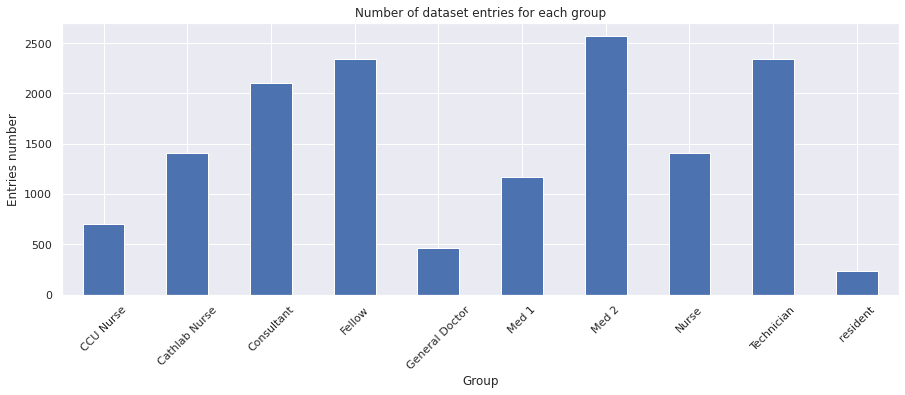

In [22]:
fig = plt.figure()
g = grid_groups.plot.bar()
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set_title(f"Number of dataset entries for each group")
g.set_ylabel("Entries number")
plt.show()

This distribution of groups is proportional to long/short dataset, becasue these are the same data but with other areas of interest. Unfortunately, the dataset is unbalanced with different groups.

In [23]:
grid_group_av = grid_df.groupby("Group").mean()
grid_group_av.reset_index(inplace=True)
grid_group_av

,Group,Age,Start,Duration,Parent_Stimulus_Start,Parent_Stimulus_Duration,Hit_time_G,Time_spent_G,Time_spent_G_Percentage,Respondent_ratio_G,...,TTFF_F,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks
0,CCU Nurse,10.666667,230626.720798,30143.162393,230626.720798,30143.162393,10452.444444,971.910256,3.196581,0.809117,...,16116.990028,314.056980,1.007123,0.545584,0.695157,3.830484,9.511396,20.451567,21.685185,0.000000
1,Cathlab Nurse,0.000000,192755.959402,23524.926638,192755.959402,23524.926638,7499.074074,903.055556,3.808405,0.875356,...,9515.856125,461.490741,1.904558,0.599003,0.784188,2.868946,8.433048,52.133903,51.417379,0.001425
2,Consultant,9.333333,179318.959639,20179.446819,179318.959639,20179.446819,7313.218424,707.201330,3.398860,0.828110,...,9685.638177,302.732194,1.516144,0.461064,0.680912,2.012346,6.579772,37.926401,36.742640,0.003324
3,Fellow,9.700000,177001.815385,24041.401282,177001.815385,24041.401282,8347.129915,872.466239,3.586325,0.854274,...,10446.269231,456.896154,1.944444,0.545299,0.752564,2.550855,9.126496,43.167521,42.832479,0.000000
4,General Doctor,0.000000,244408.713675,30152.311966,244408.713675,30152.311966,10136.559829,1120.967949,3.692308,0.807692,...,15335.425214,631.702991,2.072650,0.549145,0.728632,2.814103,12.792735,43.886752,41.059829,0.023504
5,Med 1,8.000000,210150.752991,29829.956410,210150.752991,29829.956410,10617.704274,1035.374359,3.444444,0.862393,...,14210.472650,444.697436,1.461538,0.560684,0.728205,3.035897,9.594017,30.153846,32.223077,0.006838
6,Med 2,2.000000,215341.866356,28815.996503,215341.866356,28815.996503,9658.739705,1073.680653,3.712121,0.843046,...,13550.565657,568.352370,1.986014,0.575758,0.754079,2.878399,9.949106,47.037685,46.371795,0.004662
7,Nurse,0.000000,212498.818376,30078.620370,212498.818376,30078.620370,11577.400285,956.981481,3.166667,0.853989,...,15437.347578,524.762821,1.704416,0.549145,0.732194,2.884615,9.809117,38.039886,37.033476,0.004274
8,Technician,0.000000,242645.221795,28643.231197,242645.221795,28643.231197,9429.294872,1041.903846,3.594444,0.914530,...,11147.521795,467.864530,1.607265,0.681624,0.826496,3.611966,10.835897,40.447009,37.468803,0.001282
9,resident,0.000000,205032.512821,30073.358974,205032.512821,30073.358974,10416.606838,1181.290598,3.914530,0.940171,...,11148.401709,474.555556,1.542735,0.786325,0.888889,4.717949,14.957265,27.064103,28.106838,0.000000


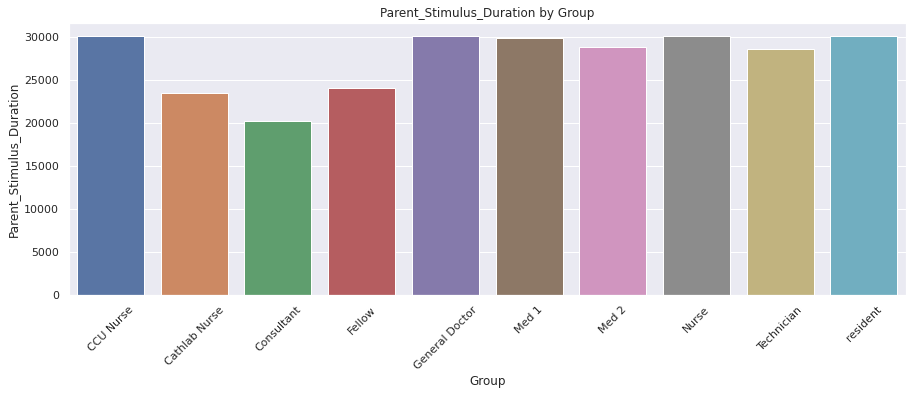

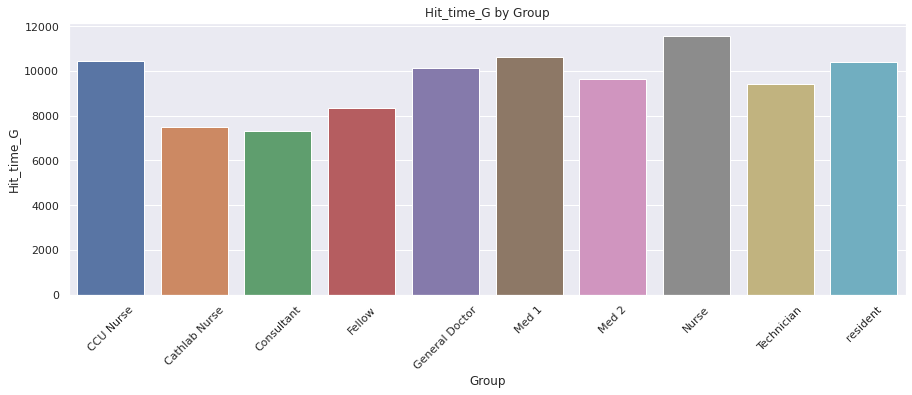

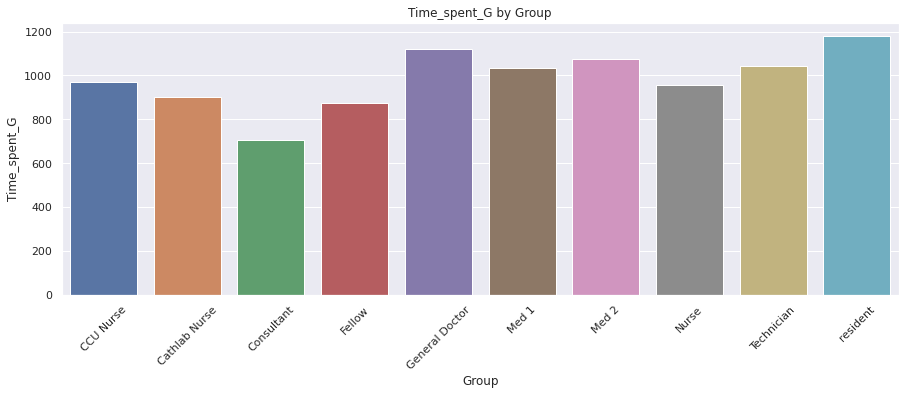

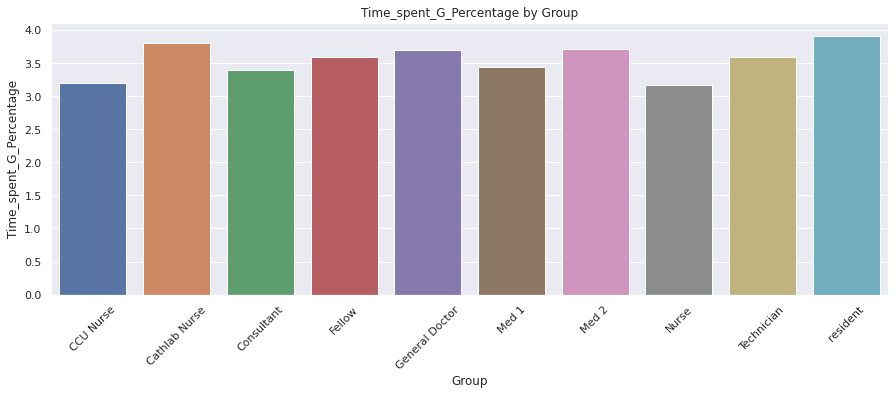

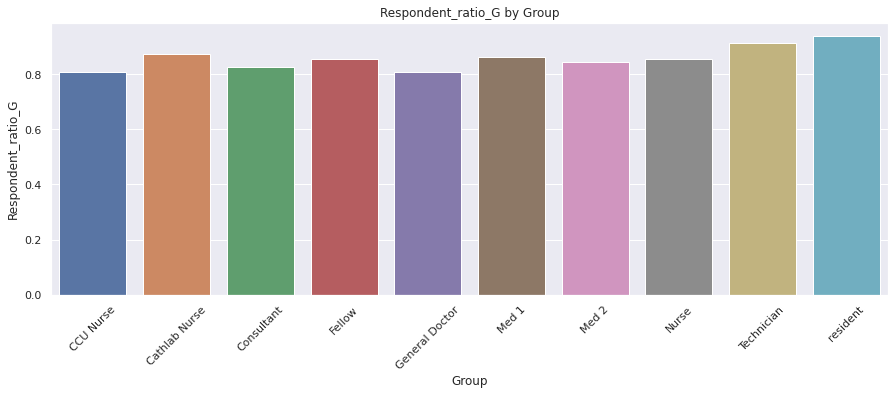

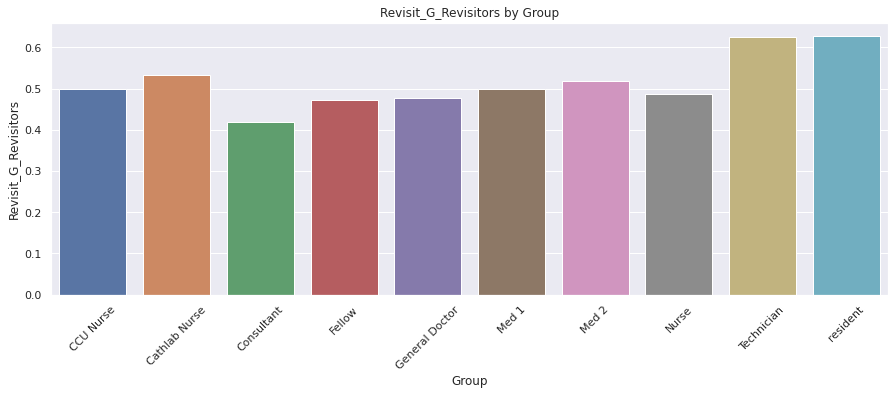

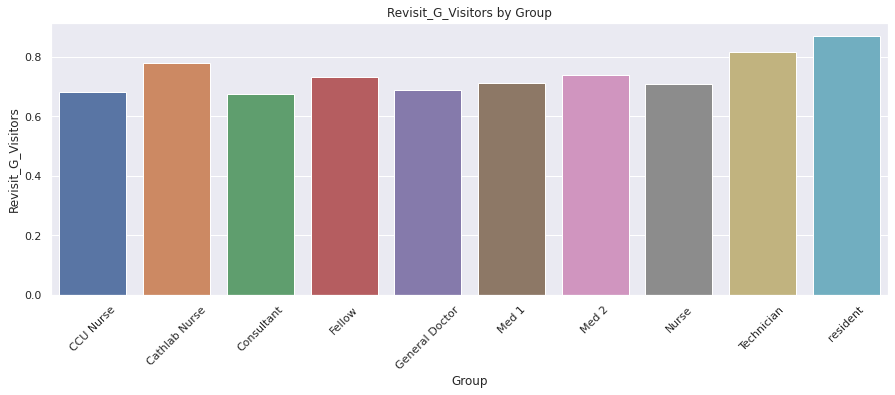

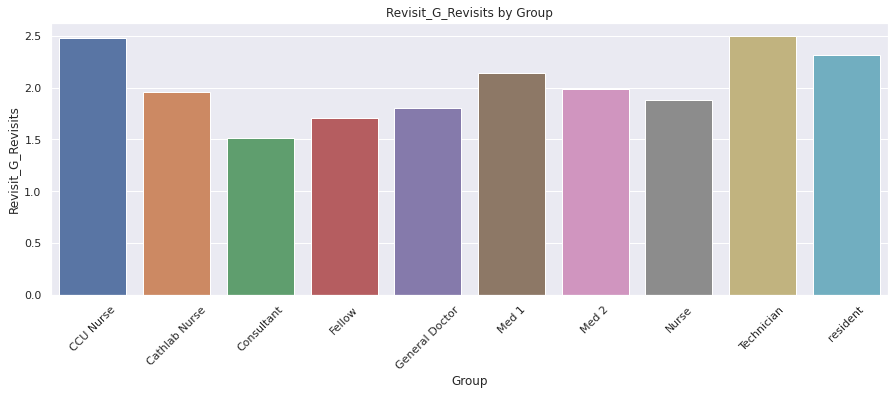

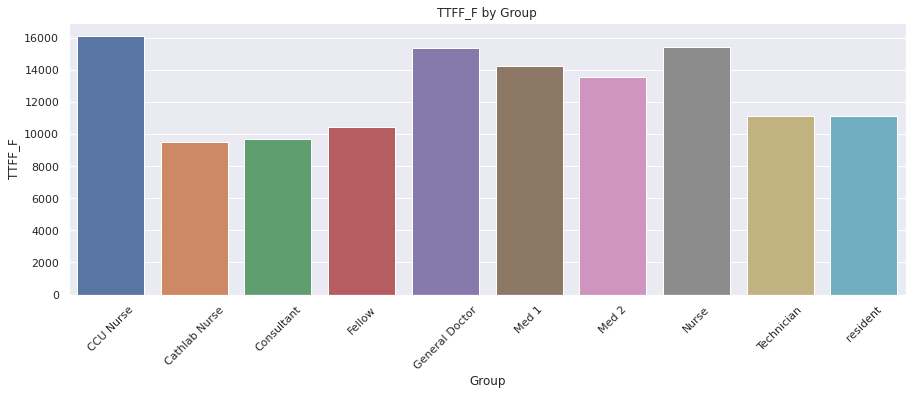

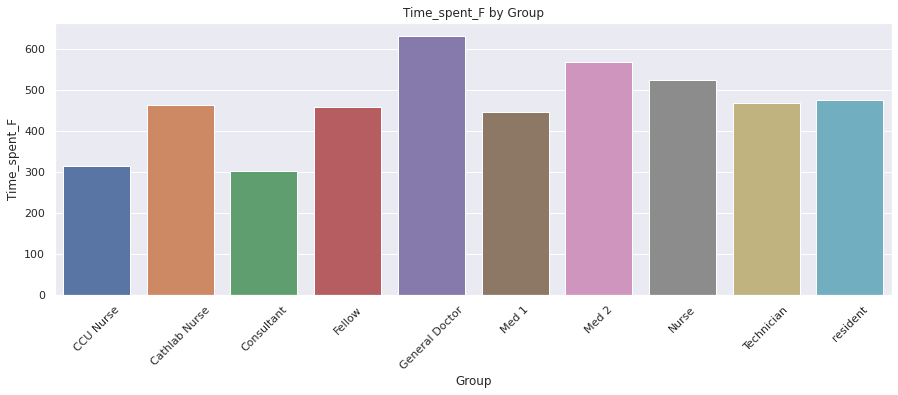

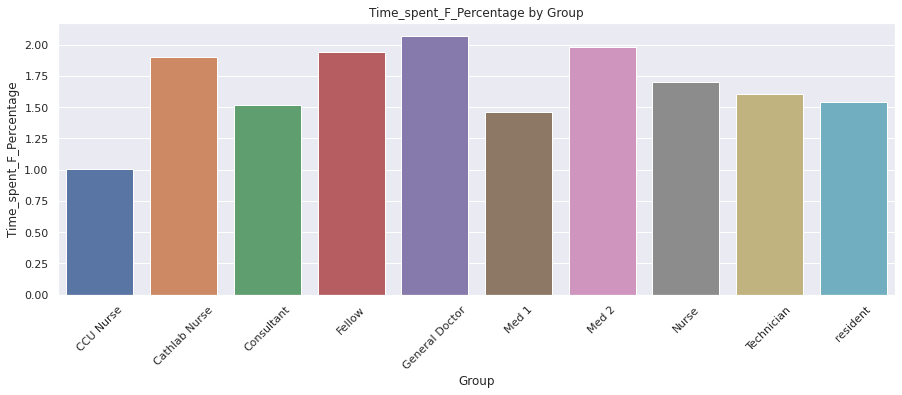

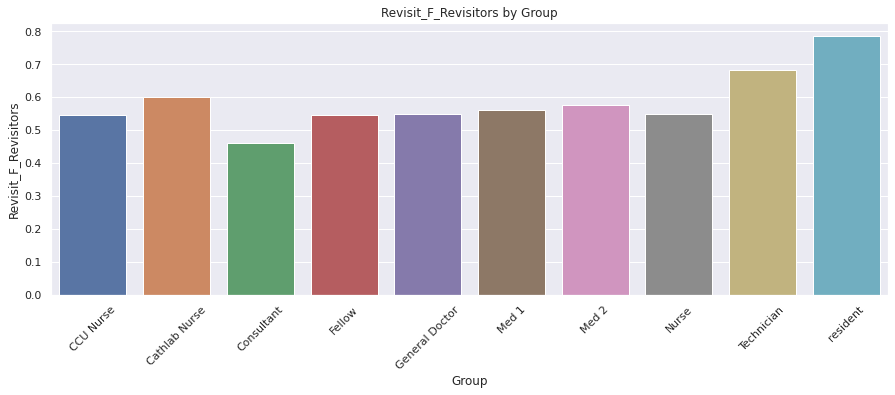

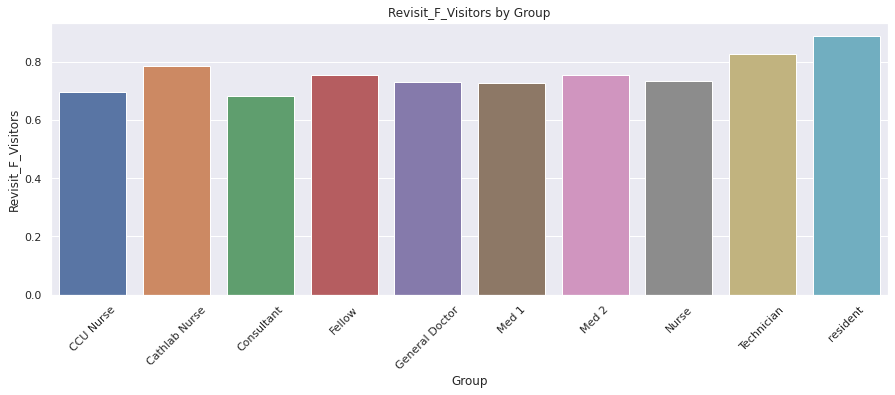

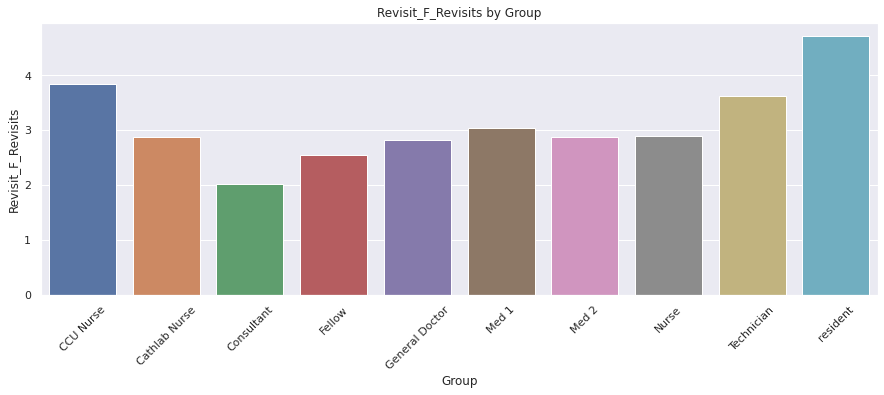

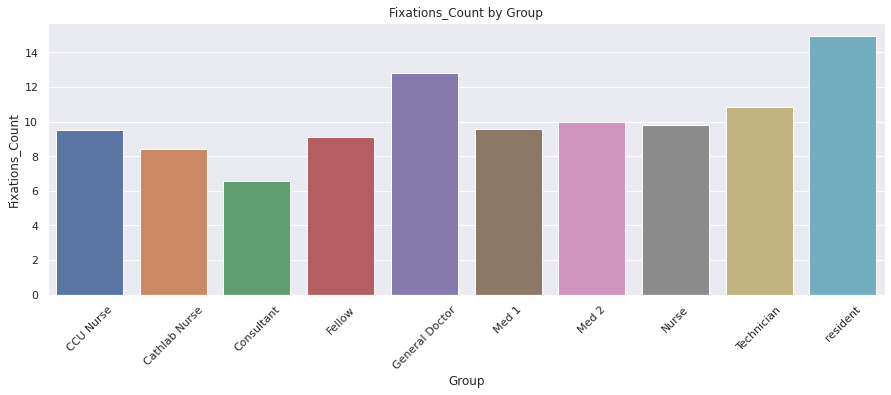

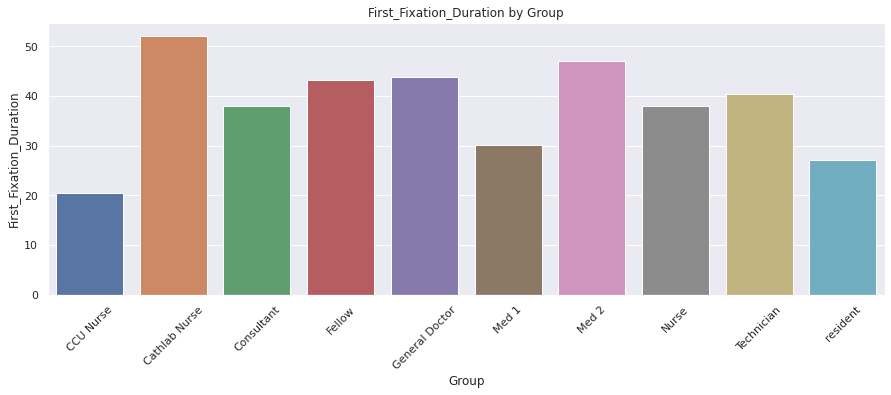

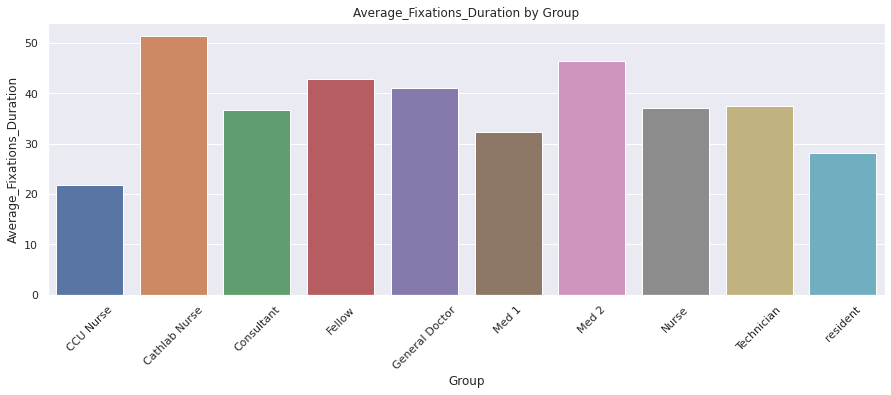

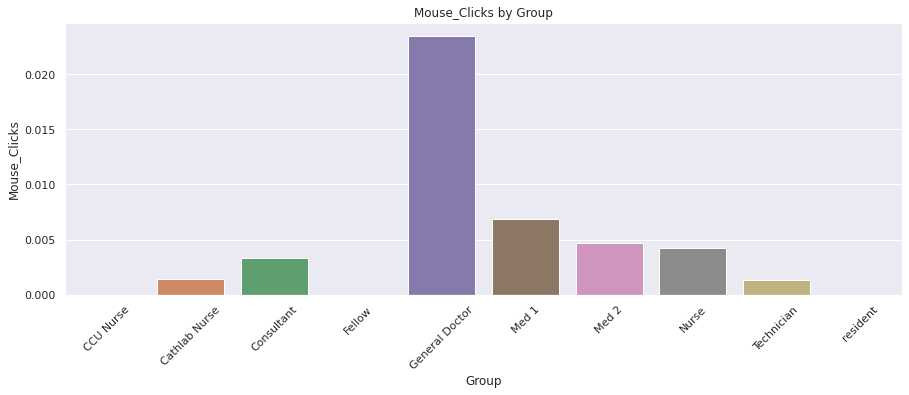

In [24]:
plot_all_cols(grid_group_av, "Group")

Durations distributions are the same as for long/short AOIs, because these are kind of the same experiments but with different Areas of Interest.

What is interesting here is that Hit time for gazing doesn't give as much insight as for long/short AOIs. Nurses still take the most time, but is is not as drastically more than for other categories. Every group is approximately the same here and it would be hard to distinguish between them by this parameter.

Time spent gazing is very similar to long/short AOIs: residents spend the most time, consultants spend the least time in miliseconds, but everyting normalizes in percents.

Respondent ratio here is lower, as there are no 1 values, unlike for long/short AOIs. That is because we much more data and the areas are smaller, that's why the probability that it will not be visited is higher.

(Re)visitors and revisits are a bit more meaningful than for long/short AOIs, although they are still quite similar. The more (re)visitors are reached by residents and technicians. As for revisits, the highest values get technicians, CCU nurses, and residents. As for long/short AOIs, this applies to both gazing and fixating.

Time to first fixation, similarly to time to first gazing, doesn't show as much as in long/short AOIs. These two values are high for nurses and CCU nurses (as for long/short AOIs), but alongside with them are also general doctors and medical students of 1st and 2nd years. These are too many categories to give meaning.

Time spent fixating, similarly to long/short AOIs, is also not so meaningful. We can see that CCU nurses have very small values, especially in percents, because consultant also spend little time fixating in miliseconds, but have more percentage. General doctors apend the most time fixating, but alongside with them are senior medical students. Fellows and cathlab nurses apend much time in percents too, and overall all categories are quite similar even when different, so it's hard to say anything about this parameter.

As for long/short AOIs, the most fixations have residents and general doctors. Consultants have the least fixations.

The longest first fixation is by cathlab nurses, and the shortest - by CCU nurses, which quite differs from long/short AOIs.

Average fixation duration has the same distribution as both first fixation duration and avarage fixation duration for long/short AOIs. It makes sense, because average fixations are the same no matter what areas of interest we have.

The same as with long/short AOIs, mouse clicks make mostly only general doctors, however, too small amount of them to make a difference.

### Group by Areas of Interest

As there are too many areas of interest, we will not consider them together with groups this time, but only separately.

In [25]:
%%capture --no-display
def normalize_label(label):
    return label.split()[0]
grid_df["Label"] = grid_df["Label"].apply(lambda row: normalize_label(row))
grid_df

,Study_name,Respondent_Name,Gender,Age,Group,Type,Label,Start,Duration,ParentStimulus,...,TTFF_F,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks
0,ECG Study,Resident,MALE,0,resident,Static AOI,V5-1,178603,30068,Normal sinus rhythm,...,5814.0,150.0,1.0,1.0,1.0,5.0,9.0,17.0,17.0,0.0
1,ECG Study,Resident,MALE,0,resident,Static AOI,II-1,178603,30068,Normal sinus rhythm,...,6064.0,1050.0,3.0,1.0,1.0,5.0,29.0,34.0,36.0,0.0
2,ECG Study,Resident,MALE,0,resident,Static AOI,V1-1,178603,30068,Normal sinus rhythm,...,5481.0,133.0,0.0,1.0,1.0,2.0,4.0,33.0,33.0,0.0
3,ECG Study,Resident,MALE,0,resident,Static AOI,1,178603,30068,Normal sinus rhythm,...,748.0,433.0,1.0,1.0,1.0,6.0,11.0,33.0,39.0,0.0
4,ECG Study,Resident,MALE,0,resident,Static AOI,aVR,178603,30068,Normal sinus rhythm,...,3498.0,884.0,3.0,1.0,1.0,3.0,20.0,17.0,44.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14737,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,II-3,353029,30127,Complete heart block,...,27063.0,16.0,0.0,0.0,1.0,0.0,1.0,16.0,16.0,0.0
14738,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,II-4,353029,30127,Complete heart block,...,30119.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0
14739,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,V5-2,353029,30127,Complete heart block,...,25561.0,349.0,1.0,1.0,1.0,3.0,8.0,16.0,44.0,0.0
14740,ECG Study,Med 2-3,MALE,0,Med 2,Static AOI,V5-3,353029,30127,Complete heart block,...,26763.0,384.0,1.0,1.0,1.0,3.0,12.0,17.0,32.0,0.0


In [26]:
grid_aoi_av = grid_df.groupby("Label").mean()
grid_aoi_av.reset_index(inplace=True)
grid_aoi_av

,Label,Age,Start,Duration,Parent_Stimulus_Start,Parent_Stimulus_Duration,Hit_time_G,Time_spent_G,Time_spent_G_Percentage,Respondent_ratio_G,...,TTFF_F,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks
0,1,4.365079,207304.317460,26654.380952,207304.317460,26654.380952,5456.419048,1430.833333,5.236508,0.871429,...,8134.133333,933.582540,3.428571,0.634921,0.817460,3.012698,13.174603,63.703175,64.666667,0.000000
1,2,4.365079,207304.317460,26654.380952,207304.317460,26654.380952,5945.000000,1655.957143,6.350794,0.960317,...,6536.784127,929.044444,3.595238,0.790476,0.911111,4.582540,16.371429,52.357143,56.066667,0.001587
2,3,4.365079,207304.317460,26654.380952,207304.317460,26654.380952,8146.984127,1127.042857,4.300000,0.960317,...,8478.111111,545.926984,2.111111,0.719048,0.890476,3.696825,10.874603,47.711111,47.487302,0.003175
3,II-1,4.365079,207304.317460,26654.380952,207304.317460,26654.380952,9333.215873,1221.149206,4.379365,0.882540,...,11585.861905,522.206349,1.865079,0.630159,0.792063,3.511111,12.069841,34.995238,35.917460,0.001587
4,II-2,4.365079,207304.317460,26654.380952,207304.317460,26654.380952,9922.546032,1094.461905,4.039683,0.926984,...,11177.653968,418.334921,1.579365,0.673016,0.807937,3.658730,10.420635,35.588889,32.874603,0.003175
5,II-3,4.365079,205534.789322,26543.920635,205534.789322,26543.920635,11083.210678,866.203463,3.199134,0.877345,...,13729.558442,323.193362,1.207792,0.538240,0.741703,2.888889,8.494949,36.683983,34.519481,0.001443
6,II-4,4.365079,209467.074074,26789.388007,209467.074074,26789.388007,11957.557319,351.585538,1.285714,0.664903,...,19984.396825,125.005291,0.451499,0.262787,0.472663,1.134039,3.499118,17.858907,17.216931,0.000000
7,Information,4.365079,205959.600529,26542.706349,205959.600529,26542.706349,12983.068783,177.068783,0.568783,0.603175,...,21710.994709,52.896825,0.148148,0.169312,0.335979,0.605820,1.399471,9.314815,10.063492,0.000000
8,V1,4.365079,207304.317460,26654.380952,207304.317460,26654.380952,8947.288889,1014.955556,3.877778,0.868254,...,11790.393651,607.253968,2.307937,0.580952,0.790476,2.534921,10.098413,56.239683,54.738095,0.000000
9,V1-1,4.365079,206526.198413,26477.571429,206526.198413,26477.571429,9648.222222,1001.271825,3.676587,0.908730,...,10893.130952,458.021825,1.660714,0.644841,0.815476,3.210317,10.073413,41.478175,38.783730,0.000000


We have a problem here, because there are different labels for some of diagnosises: for example, there are V7 and V8 areas for hyperkalemia, but not for oter diagnosises. We'll have to keep this in mind when building a classifier, maybe this field needs to be removed, because in can leak the data. However, this data shouldn't leak anything about the group, so it can remain.

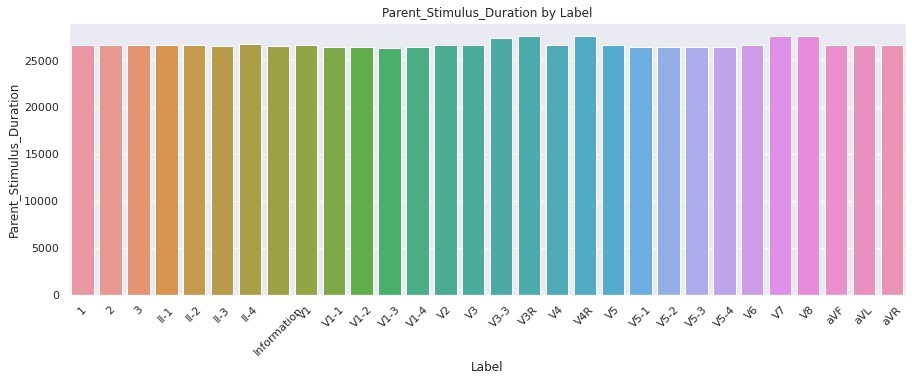

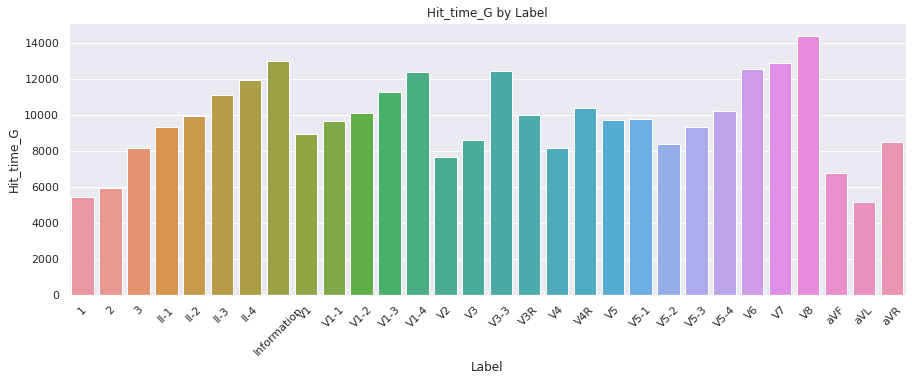

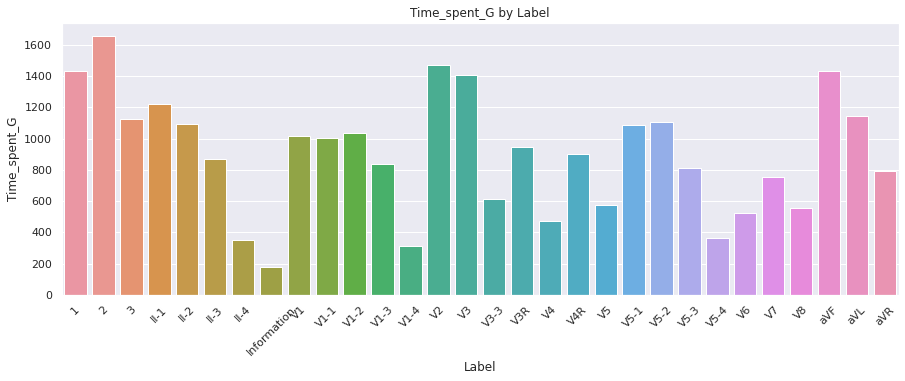

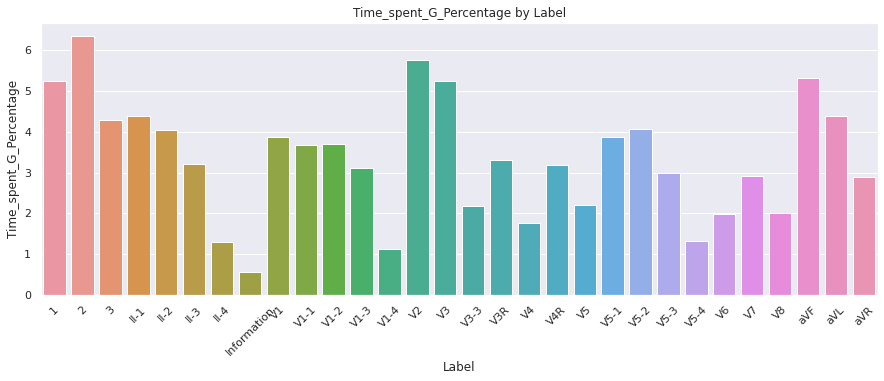

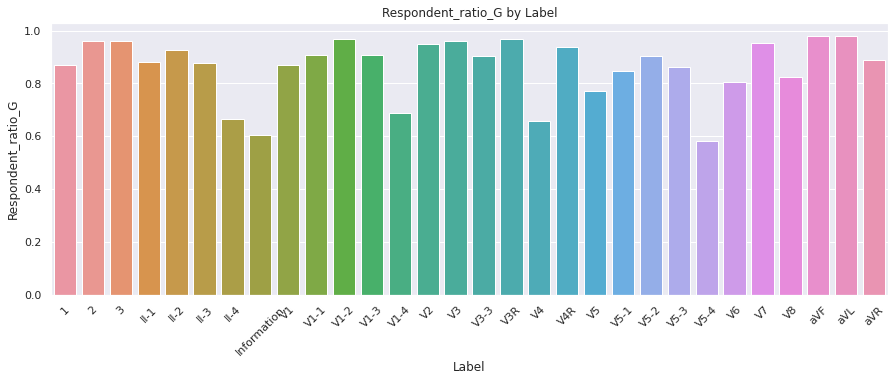

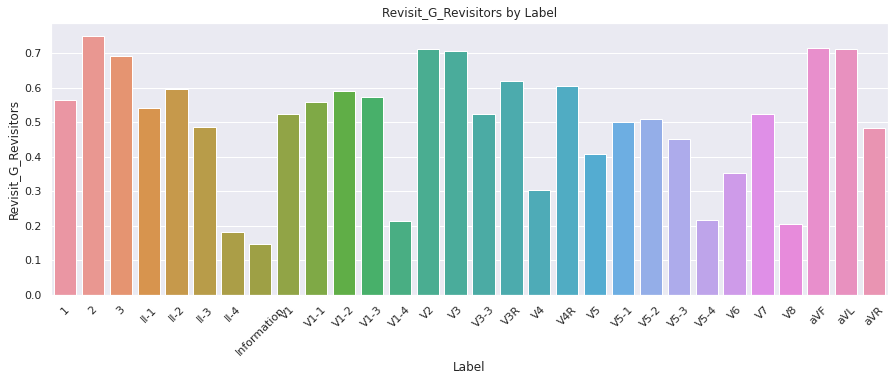

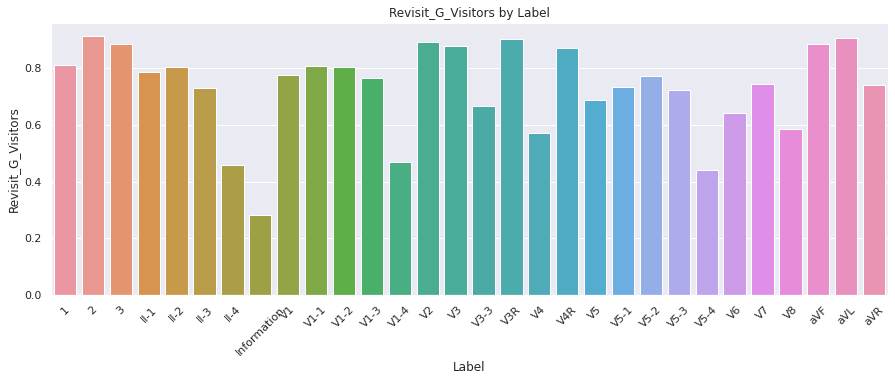

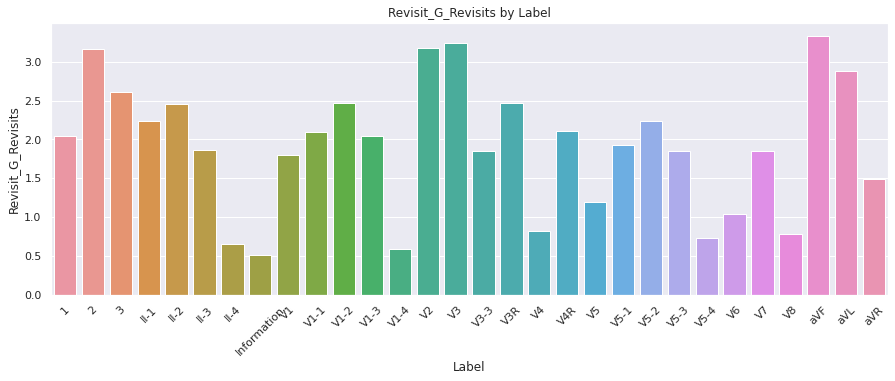

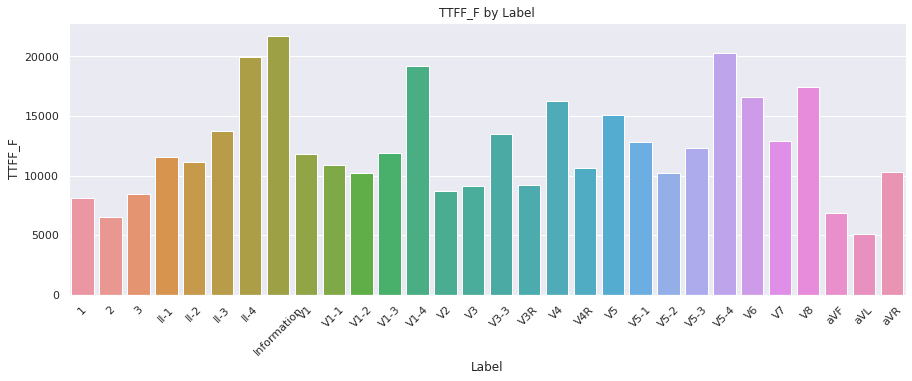

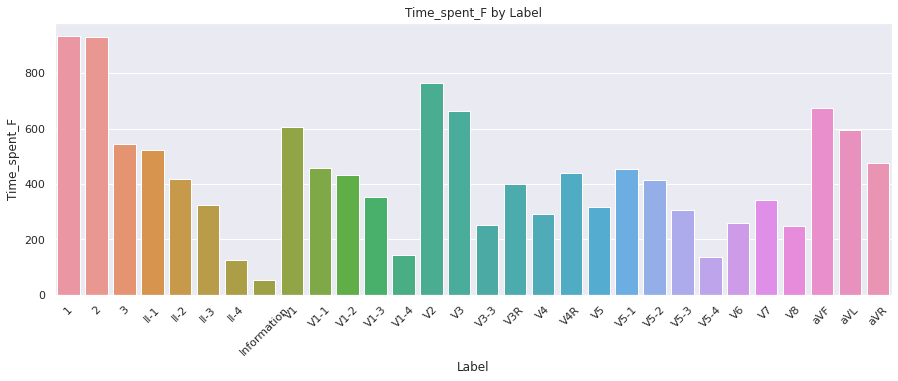

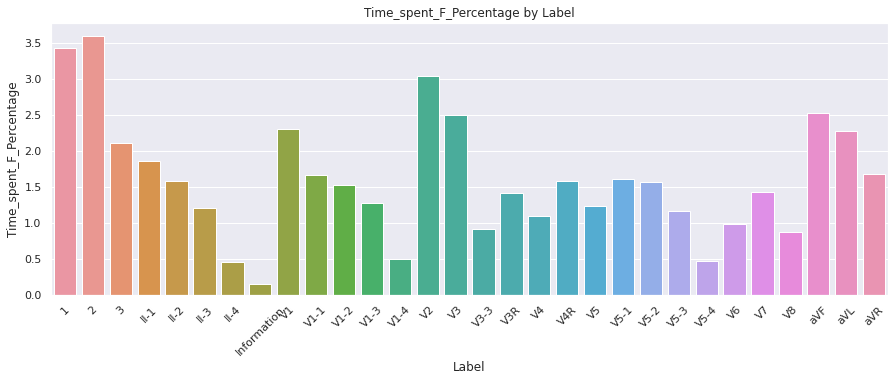

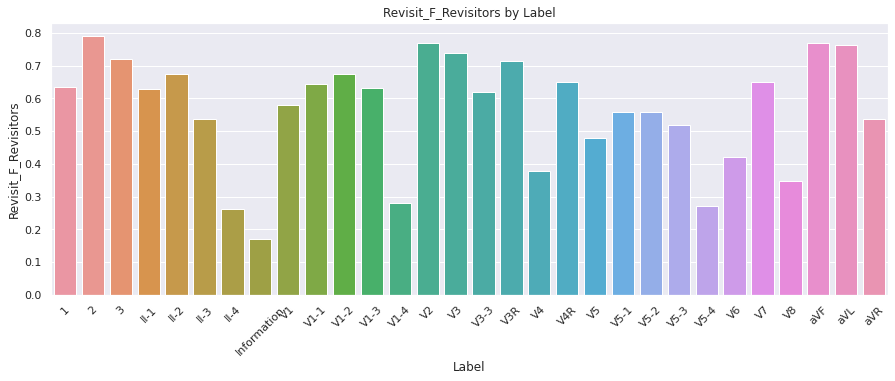

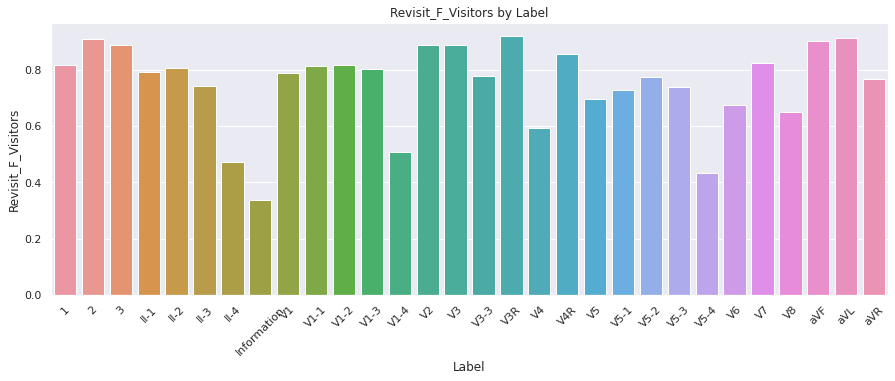

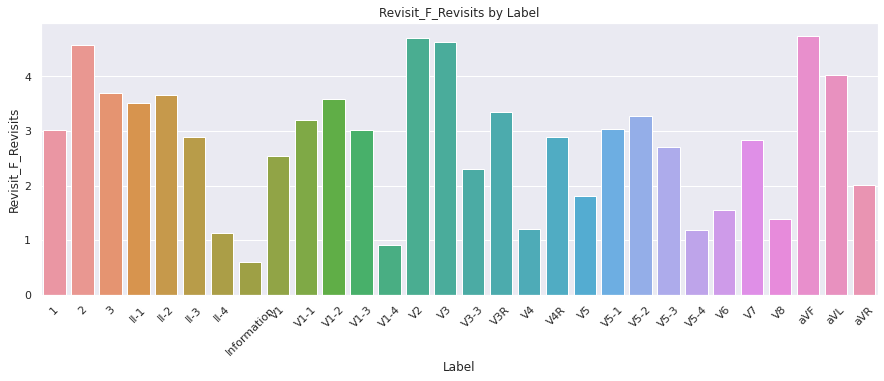

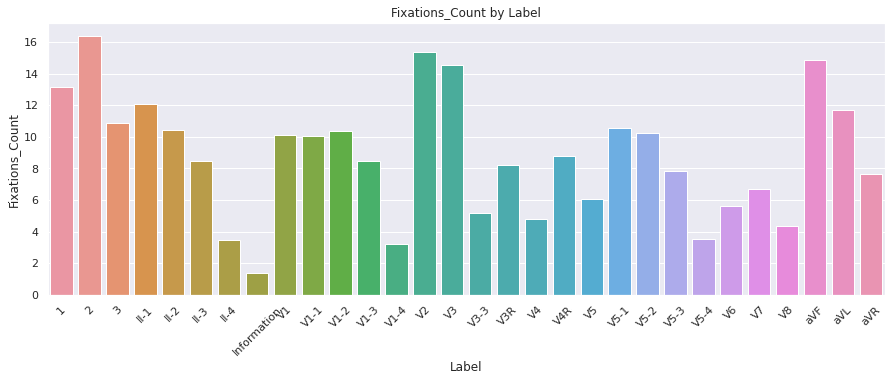

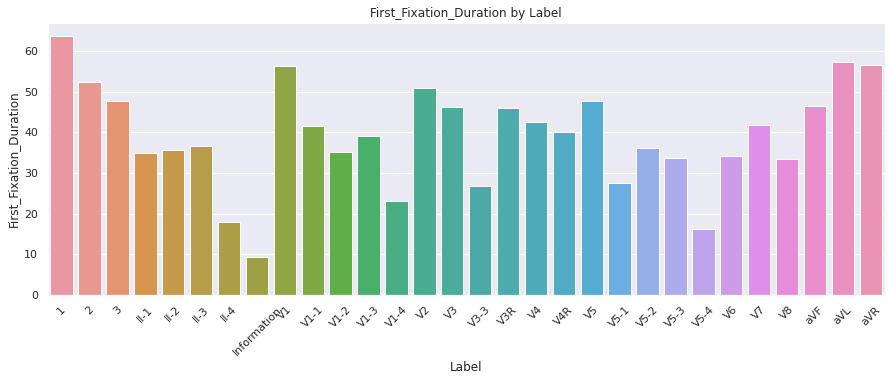

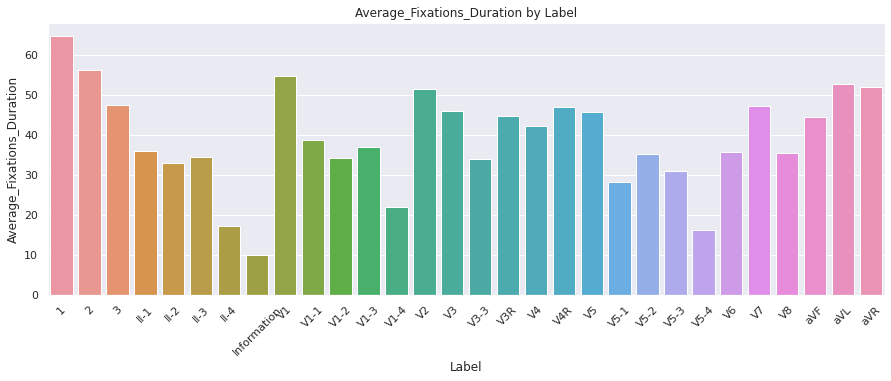

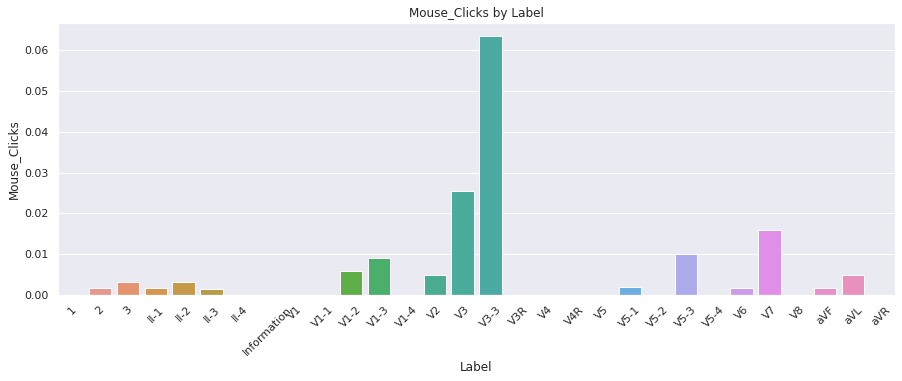

In [27]:
plot_all_cols(grid_aoi_av, "Label")

There are so many areas of interest that it is hard to see any dependencies, but let's try to find out something interesting.

Duration is the same for all areas of interest with just a small differences for some of them. That is because all participants get to have approximately the same areas of interest, so the duration for all areas of interests is just average duration for different experiments and participants.

Hit time for gazing has an interesting distribution: if we take a deeper look into it, we can see that people look from left to right and from up to down (the bars go like stairs for the values in row/column). The similar thing happens with time to first fixation.

Time spent gazing shows an opposite yet logical thing: people gaze longer at the areas that they reach easier. For example, people gaze much more at the areas of interest in the upper left corner than in lower right corner. They also gaze a lot at the center (aVF, aVL, V2, V3). The same tendency is with time spent fixating, all (re)visits, fixations count, first and average fixation duration.

Respondent ratio shows the unpopular areas: Information, V5-4, II-4, V1-4, V4 - almost whole right column.

Mouse clicks are most often at V3-3 (center).

# Classification

## Long/Short AOIs

In [28]:
long_short_df.head()

,Study_name,Respondent_Name,Gender,Age,Group,Type,Label,Start,Duration,ParentStimulus,...,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks,CorrectLabel
0,ECG Study,Resident,MALE,0,resident,Static AOI,Short,178603,30068,Normal sinus rhythm,...,7250.0,24.0,1.0,1.0,41.0,229.0,17.0,32.0,0.0,Normal sinus rhythm
1,ECG Study,Resident,MALE,0,resident,Static AOI,Long,178603,30068,Normal sinus rhythm,...,3602.0,12.0,1.0,1.0,19.0,125.0,17.0,29.0,0.0,Normal sinus rhythm
2,ECG Study,Resident,MALE,0,resident,Static AOI,Short,309389,30054,Atrial fibrillation,...,4499.0,15.0,1.0,1.0,11.0,130.0,33.0,35.0,0.0,Atrial fibrillation
3,ECG Study,Resident,MALE,0,resident,Static AOI,Long,309389,30054,Atrial fibrillation,...,6603.0,22.0,1.0,1.0,47.0,218.0,17.0,30.0,0.0,Atrial fibrillation
4,ECG Study,Resident,MALE,0,resident,Static AOI,Short,72977,30080,hyperkalemia,...,8230.0,27.0,1.0,1.0,25.0,212.0,33.0,39.0,0.0,hyperkalemia


In [29]:
long_short_df["Study_name"].unique()

array(['ECG Study'], dtype=object)

There is only one value in study name columns, so it has no use and can be deleted.

In [30]:
long_short_df["Gender"].unique()

array(['MALE', 'FEMALE'], dtype=object)

In [31]:
%%capture --no-display
def normalize_gender(gender):
    if gender == "MALE":
        return 0
    return 1

long_short_df["Gender"] = long_short_df["Gender"].apply(lambda row: normalize_gender(row))

In [32]:
long_short_df.groupby("Age").size()

Age
0     1080
20      40
22      20
30      20
32      20
33      20
34      20
40      20
44      20
dtype: int64

Most of the values in the age column are zeros, so it is useless and should be deleted.

In [33]:
long_short_df["Type"].unique()

array(['Static AOI'], dtype=object)

Once again, we have only one value in type column, that's why we can remove the column.

In [34]:
%%capture --no-display
def normalize_label_long_short(label):
    if label == "Long":
        return 0
    return 1

long_short_df["Label"] = long_short_df["Label"].apply(lambda row: normalize_label_long_short(row))

In [35]:
diagnosises = long_short_df["ParentStimulus"].unique()
print(diagnosises, len(diagnosises))

['Normal sinus rhythm' 'Atrial fibrillation' 'hyperkalemia'
 'Atrial flutter' 'Ventricular tachycardia'
 'Wolf Parkinson White syndrome' 'Ventricular paced rhythm'
 'Left bundle branch block' 'ST elevation MI' 'Complete heart block'] 10


In [36]:
diagnosises_dict = dict(zip(diagnosises, range(len(diagnosises))))
diagnosises_dict

{'Normal sinus rhythm': 0,
 'Atrial fibrillation': 1,
 'hyperkalemia': 2,
 'Atrial flutter': 3,
 'Ventricular tachycardia': 4,
 'Wolf Parkinson White syndrome': 5,
 'Ventricular paced rhythm': 6,
 'Left bundle branch block': 7,
 'ST elevation MI': 8,
 'Complete heart block': 9}

In [37]:
%%capture --no-display
def normalize_diagnosises(diag):
    return diagnosises_dict[diag]

long_short_df["ParentStimulus"] = long_short_df["ParentStimulus"].apply(lambda row: normalize_diagnosises(row))

First let's remove data that leak labels or is unneeded.

In [38]:
del long_short_df["Study_name"]
del long_short_df["Respondent_Name"]
del long_short_df["Age"]
del long_short_df["CorrectLabel"]
del long_short_df["Type"]
del long_short_df["Duration"] # these 4 columns must be removed due to reasons explained later in the grid section
del long_short_df["Parent_Stimulus_Duration"]
del long_short_df["Start"]
del long_short_df["Parent_Stimulus_Start"]

In [39]:
long_short_df.head()

,Gender,Group,Label,ParentStimulus,Hit_time_G,Time_spent_G,Time_spent_G_Percentage,Respondent_ratio_G,Revisit_G_Revisitors,Revisit_G_Visitors,...,TTFF_F,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks
0,0,resident,1,0,1625.0,18627.0,62.0,1.0,1.0,1.0,...,265.0,7250.0,24.0,1.0,1.0,41.0,229.0,17.0,32.0,0.0
1,0,resident,0,0,125.0,10213.0,34.0,1.0,1.0,1.0,...,15.0,3602.0,12.0,1.0,1.0,19.0,125.0,17.0,29.0,0.0
2,0,resident,1,1,2375.0,9811.0,33.0,1.0,1.0,1.0,...,285.0,4499.0,15.0,1.0,1.0,11.0,130.0,33.0,35.0,0.0
3,0,resident,0,1,125.0,18173.0,61.0,1.0,1.0,1.0,...,68.0,6603.0,22.0,1.0,1.0,47.0,218.0,17.0,30.0,0.0
4,0,resident,1,2,3375.0,16954.0,56.0,1.0,1.0,1.0,...,39.0,8230.0,27.0,1.0,1.0,25.0,212.0,33.0,39.0,0.0


In [40]:
X = long_short_df.drop("Group", axis=1)
y = long_short_df["Group"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

In [41]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))

In [42]:
X_test = pd.DataFrame(scaler.transform(X_test))

In [43]:
y_train.value_counts()

Med 2             165
Fellow            150
Technician        150
Consultant        135
Cathlab Nurse      90
Nurse              90
Med 1              75
CCU Nurse          45
General Doctor     30
resident           15
Name: Group, dtype: int64

In [44]:
strategy = {"Med 2":200, "Fellow":200, "Technician":200, "Consultant":200, "Cathlab Nurse":200, "Nurse":200, "Med 1": 200, "CCU Nurse": 200, "General Doctor": 200, "resident": 200}
sm = SMOTE(random_state=2, sampling_strategy=strategy)

In [45]:
%%capture --no-display
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [46]:
y_train_res.value_counts()

resident          200
Fellow            200
General Doctor    200
Med 1             200
Technician        200
Cathlab Nurse     200
Nurse             200
Med 2             200
Consultant        200
CCU Nurse         200
Name: Group, dtype: int64

In [47]:
model_svc = SVC(C=1e1, gamma=1e-1)
model_svc.fit(X_train_res, y_train_res)
y_pred = model_svc.predict(X_test)

In [48]:
accuracy_score(y_test, y_pred)

0.34285714285714286

In [49]:
classification_report(y_test, y_pred)

'                precision    recall  f1-score   support\n\n     CCU Nurse       0.10      0.13      0.11        15\n Cathlab Nurse       0.28      0.30      0.29        30\n    Consultant       0.46      0.38      0.41        45\n        Fellow       0.44      0.36      0.40        50\nGeneral Doctor       0.08      0.10      0.09        10\n         Med 1       0.15      0.16      0.15        25\n         Med 2       0.54      0.51      0.52        55\n         Nurse       0.37      0.43      0.40        30\n    Technician       0.29      0.30      0.29        50\n      resident       0.14      0.20      0.17         5\n\n      accuracy                           0.34       315\n     macro avg       0.29      0.29      0.28       315\n  weighted avg       0.36      0.34      0.35       315\n'

In [50]:
model_dt = DecisionTreeClassifier(class_weight='balanced', random_state=1, max_depth=15)
model_dt.fit(X_train_res, y_train_res)
y_pred = model_dt.predict(X_test)

In [51]:
accuracy_score(y_test, y_pred)

0.25396825396825395

In [52]:
classification_report(y_test, y_pred)

'                precision    recall  f1-score   support\n\n     CCU Nurse       0.21      0.33      0.26        15\n Cathlab Nurse       0.19      0.10      0.13        30\n    Consultant       0.39      0.42      0.40        45\n        Fellow       0.26      0.24      0.25        50\nGeneral Doctor       0.00      0.00      0.00        10\n         Med 1       0.07      0.08      0.07        25\n         Med 2       0.38      0.36      0.37        55\n         Nurse       0.34      0.33      0.34        30\n    Technician       0.24      0.18      0.20        50\n      resident       0.00      0.00      0.00         5\n\n      accuracy                           0.25       315\n     macro avg       0.21      0.21      0.20       315\n  weighted avg       0.27      0.25      0.26       315\n'

In [53]:
dict(zip(X.columns, model_dt.feature_importances_))

{'Gender': 0.0524356360282428,
 'Label': 0.04141158327759378,
 'ParentStimulus': 0.0658172121899004,
 'Hit_time_G': 0.03557161668423684,
 'Time_spent_G': 0.04824052029215571,
 'Time_spent_G_Percentage': 0.06106239701942326,
 'Respondent_ratio_G': 0.0,
 'Revisit_G_Revisitors': 0.0009525620679804793,
 'Revisit_G_Visitors': 0.0,
 'Revisit_G_Revisits': 0.0953214812984839,
 'TTFF_F': 0.0806273996358755,
 'Time_spent_F': 0.04435349693512861,
 'Time_spent_F_Percentage': 0.06681225799066298,
 'Revisit_F_Revisitors': 0.0,
 'Revisit_F_Visitors': 0.0,
 'Revisit_F_Revisits': 0.08846604302348143,
 'Fixations_Count': 0.06558406594352965,
 'First_Fixation_Duration': 0.09217510451111767,
 'Average_Fixations_Duration': 0.13858826852358716,
 'Mouse_Clicks': 0.022580354578599835}

In [54]:
model_rf = RandomForestClassifier(class_weight='balanced', random_state=1, max_depth=20, n_estimators=1000)
model_rf.fit(X_train_res, y_train_res)
y_pred = model_rf.predict(X_test)

In [55]:
accuracy_score(y_test, y_pred)

0.35873015873015873

In [56]:
classification_report(y_test, y_pred)

'                precision    recall  f1-score   support\n\n     CCU Nurse       0.18      0.27      0.22        15\n Cathlab Nurse       0.40      0.27      0.32        30\n    Consultant       0.47      0.51      0.49        45\n        Fellow       0.41      0.30      0.34        50\nGeneral Doctor       0.12      0.20      0.15        10\n         Med 1       0.19      0.16      0.17        25\n         Med 2       0.43      0.42      0.43        55\n         Nurse       0.52      0.57      0.54        30\n    Technician       0.29      0.30      0.30        50\n      resident       0.15      0.40      0.22         5\n\n      accuracy                           0.36       315\n     macro avg       0.32      0.34      0.32       315\n  weighted avg       0.37      0.36      0.36       315\n'

In [57]:
dict(zip(X.columns, model_rf.feature_importances_))

{'Gender': 0.051785670956304986,
 'Label': 0.031094690657268654,
 'ParentStimulus': 0.06014684927236443,
 'Hit_time_G': 0.05319686596716288,
 'Time_spent_G': 0.07111482378783919,
 'Time_spent_G_Percentage': 0.07390671987428873,
 'Respondent_ratio_G': 0.00021545028660595772,
 'Revisit_G_Revisitors': 0.0017848588598108263,
 'Revisit_G_Visitors': 0.00025669913111167126,
 'Revisit_G_Revisits': 0.08204647797402226,
 'TTFF_F': 0.07649147017554186,
 'Time_spent_F': 0.0754480219391156,
 'Time_spent_F_Percentage': 0.07197364570289894,
 'Revisit_F_Revisitors': 0.0011325661527115975,
 'Revisit_F_Visitors': 0.00015892716902681832,
 'Revisit_F_Revisits': 0.08325707463975177,
 'Fixations_Count': 0.08090839858607711,
 'First_Fixation_Duration': 0.06939151653656246,
 'Average_Fixations_Duration': 0.10188321155762711,
 'Mouse_Clicks': 0.013806060773907164}

For long/short dataset the maximum accuracy is around 30%. Unfortunately, there is too little data for classifier to work more precisely. Random forest and SVC work the best, while Decision tree works very poorly.

## Grid AOIs

In [58]:
grid_df.head()

,Study_name,Respondent_Name,Gender,Age,Group,Type,Label,Start,Duration,ParentStimulus,...,TTFF_F,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks
0,ECG Study,Resident,MALE,0,resident,Static AOI,V5-1,178603,30068,Normal sinus rhythm,...,5814.0,150.0,1.0,1.0,1.0,5.0,9.0,17.0,17.0,0.0
1,ECG Study,Resident,MALE,0,resident,Static AOI,II-1,178603,30068,Normal sinus rhythm,...,6064.0,1050.0,3.0,1.0,1.0,5.0,29.0,34.0,36.0,0.0
2,ECG Study,Resident,MALE,0,resident,Static AOI,V1-1,178603,30068,Normal sinus rhythm,...,5481.0,133.0,0.0,1.0,1.0,2.0,4.0,33.0,33.0,0.0
3,ECG Study,Resident,MALE,0,resident,Static AOI,1,178603,30068,Normal sinus rhythm,...,748.0,433.0,1.0,1.0,1.0,6.0,11.0,33.0,39.0,0.0
4,ECG Study,Resident,MALE,0,resident,Static AOI,aVR,178603,30068,Normal sinus rhythm,...,3498.0,884.0,3.0,1.0,1.0,3.0,20.0,17.0,44.0,0.0


In [59]:
%%capture --no-display
grid_df["Gender"] = grid_df["Gender"].apply(lambda row: normalize_gender(row))

In [60]:
grid_labels = grid_df["Label"].unique()
grid_labels_dict = dict(zip(grid_labels, range(len(grid_labels))))
grid_labels_dict

{'V5-1': 0,
 'II-1': 1,
 'V1-1': 2,
 '1': 3,
 'aVR': 4,
 'V1': 5,
 'V4': 6,
 '2': 7,
 'aVL': 8,
 'V2': 9,
 'V5': 10,
 '3': 11,
 'aVF': 12,
 'V3': 13,
 'V6': 14,
 'Information': 15,
 'V1-2': 16,
 'V3-3': 17,
 'V1-4': 18,
 'II-2': 19,
 'II-3': 20,
 'II-4': 21,
 'V5-2': 22,
 'V5-3': 23,
 'V5-4': 24,
 'V4R': 25,
 'V3R': 26,
 'V7': 27,
 'V8': 28,
 'V1-3': 29}

In [61]:
%%capture --no-display
def normalize_grid_labels(label):
    return grid_labels_dict[label]

grid_df["Label"] = grid_df["Label"].apply(lambda row: normalize_grid_labels(row))

In [62]:
%%capture --no-display
grid_df["ParentStimulus"] = grid_df["ParentStimulus"].apply(lambda row: normalize_diagnosises(row))

In [63]:
del grid_df["Study_name"]
del grid_df["Respondent_Name"]
del grid_df["Type"]
del grid_df["Age"]

In [64]:
grid_df.head()

,Gender,Group,Label,Start,Duration,ParentStimulus,Parent_Stimulus_Start,Parent_Stimulus_Duration,Hit_time_G,Time_spent_G,...,TTFF_F,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks
0,0,resident,0,178603,30068,0,178603.0,30068.0,5875.0,750.0,...,5814.0,150.0,1.0,1.0,1.0,5.0,9.0,17.0,17.0,0.0
1,0,resident,1,178603,30068,0,178603.0,30068.0,6375.0,2349.0,...,6064.0,1050.0,3.0,1.0,1.0,5.0,29.0,34.0,36.0,0.0
2,0,resident,2,178603,30068,0,178603.0,30068.0,5625.0,467.0,...,5481.0,133.0,0.0,1.0,1.0,2.0,4.0,33.0,33.0,0.0
3,0,resident,3,178603,30068,0,178603.0,30068.0,875.0,1083.0,...,748.0,433.0,1.0,1.0,1.0,6.0,11.0,33.0,39.0,0.0
4,0,resident,4,178603,30068,0,178603.0,30068.0,3625.0,1533.0,...,3498.0,884.0,3.0,1.0,1.0,3.0,20.0,17.0,44.0,0.0


In [65]:
X_grid = grid_df.drop("Group", axis=1)
y_grid = grid_df["Group"]
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_grid, y_grid, test_size=0.25, stratify=y_grid, random_state=1)

In [66]:
X_train_g = pd.DataFrame(scaler.fit_transform(X_train_g))
X_test_g = pd.DataFrame(scaler.transform(X_test_g))

In [67]:
y_train_g.value_counts()

Med 2             1930
Technician        1755
Fellow            1755
Consultant        1579
Nurse             1053
Cathlab Nurse     1053
Med 1              877
CCU Nurse          527
General Doctor     351
resident           176
Name: Group, dtype: int64

In [68]:
%%capture --no-display
strategy_g = {"Med 2":2000, "Fellow":2000, "Technician":2000, "Consultant":2000, "Cathlab Nurse":2000, "Nurse":2000, "Med 1": 2000, "CCU Nurse": 2000, "General Doctor": 2000, "resident": 2000}
sm_g = SMOTE(random_state=2, sampling_strategy=strategy_g)
X_train_res_g, y_train_res_g = sm_g.fit_resample(X_train_g, y_train_g)

In [69]:
y_train_res_g.value_counts()

Med 2             2000
Consultant        2000
Technician        2000
Nurse             2000
resident          2000
General Doctor    2000
Fellow            2000
Cathlab Nurse     2000
Med 1             2000
CCU Nurse         2000
Name: Group, dtype: int64

In [70]:
model_dt.fit(X_train_res_g, y_train_res_g)
y_pred = model_dt.predict(X_test_g)

In [71]:
accuracy_score(y_test_g, y_pred)

0.9430276722734672

In [72]:
classification_report(y_test_g, y_pred)

'                precision    recall  f1-score   support\n\n     CCU Nurse       0.90      0.98      0.94       175\n Cathlab Nurse       0.97      0.97      0.97       351\n    Consultant       0.95      0.93      0.94       527\n        Fellow       0.97      0.93      0.95       585\nGeneral Doctor       0.90      0.98      0.94       117\n         Med 1       0.88      0.91      0.90       293\n         Med 2       0.95      0.95      0.95       644\n         Nurse       0.97      0.95      0.96       351\n    Technician       0.98      0.93      0.95       585\n      resident       0.60      0.93      0.73        58\n\n      accuracy                           0.94      3686\n     macro avg       0.91      0.95      0.92      3686\n  weighted avg       0.95      0.94      0.94      3686\n'

In [73]:
dict(zip(X_grid.columns, model_dt.feature_importances_))

{'Gender': 0.07604960801186761,
 'Label': 0.004313252945057962,
 'Start': 0.1545743739955755,
 'Duration': 0.14480077140488132,
 'ParentStimulus': 0.1840476654494105,
 'Parent_Stimulus_Start': 0.1326574391907172,
 'Parent_Stimulus_Duration': 0.24516008617138135,
 'Hit_time_G': 0.0015767979992789595,
 'Time_spent_G': 0.0022268091228117293,
 'Time_spent_G_Percentage': 0.0014808917747531909,
 'Respondent_ratio_G': 6.115772991420923e-05,
 'Revisit_G_Revisitors': 0.0005487516311393137,
 'Revisit_G_Visitors': 0.00035471483350241363,
 'Revisit_G_Revisits': 0.0011203606649710747,
 'TTFF_F': 0.016618904281738178,
 'Time_spent_F': 0.0025990214125993713,
 'Time_spent_F_Percentage': 0.0015536925165711797,
 'Revisit_F_Revisitors': 0.00014270136979982153,
 'Revisit_F_Visitors': 8.15436398856123e-05,
 'Revisit_F_Revisits': 0.0067422349408773315,
 'Fixations_Count': 0.001815715983906449,
 'First_Fixation_Duration': 0.00272123587188677,
 'Average_Fixations_Duration': 0.018633685081270696,
 'Mouse_Click

In [74]:
model_rf.fit(X_train_res_g, y_train_res_g)
y_pred = model_rf.predict(X_test_g)

In [75]:
accuracy_score(y_test_g, y_pred)

0.8825284861638633

In [76]:
classification_report(y_test_g, y_pred)

'                precision    recall  f1-score   support\n\n     CCU Nurse       0.87      0.94      0.90       175\n Cathlab Nurse       0.93      0.93      0.93       351\n    Consultant       0.94      0.87      0.91       527\n        Fellow       0.85      0.93      0.89       585\nGeneral Doctor       0.74      0.91      0.82       117\n         Med 1       0.87      0.84      0.85       293\n         Med 2       0.90      0.86      0.88       644\n         Nurse       0.84      0.92      0.88       351\n    Technician       0.96      0.81      0.88       585\n      resident       0.57      0.90      0.70        58\n\n      accuracy                           0.88      3686\n     macro avg       0.85      0.89      0.86      3686\n  weighted avg       0.89      0.88      0.88      3686\n'

In [77]:
dict(zip(X_grid.columns, model_rf.feature_importances_))

{'Gender': 0.05460413395152615,
 'Label': 0.04013171257410936,
 'Start': 0.09224007249985602,
 'Duration': 0.15838722155359916,
 'ParentStimulus': 0.07075737231874886,
 'Parent_Stimulus_Start': 0.09205867683539108,
 'Parent_Stimulus_Duration': 0.16114925706381486,
 'Hit_time_G': 0.030209614449934988,
 'Time_spent_G': 0.03305862910835381,
 'Time_spent_G_Percentage': 0.021048971030395464,
 'Respondent_ratio_G': 0.0016830040576029427,
 'Revisit_G_Revisitors': 0.003928352910998447,
 'Revisit_G_Visitors': 0.002379275816618979,
 'Revisit_G_Revisits': 0.017235447242345516,
 'TTFF_F': 0.06052058650249386,
 'Time_spent_F': 0.02851550030293413,
 'Time_spent_F_Percentage': 0.01746446764714477,
 'Revisit_F_Revisitors': 0.0037970440550770244,
 'Revisit_F_Visitors': 0.0013594199392361736,
 'Revisit_F_Revisits': 0.01971041879201133,
 'Fixations_Count': 0.023829306759956446,
 'First_Fixation_Duration': 0.024816164279873203,
 'Average_Fixations_Duration': 0.04078377612109941,
 'Mouse_Clicks': 0.0003315

Decision trees and random forests work very good for the bigger dataset at first sight. But if we look at feature importances we see that the most important features are those that are not connected to eye tracking parameters, but start times and durations. They take up more importance than other features, that's why we need to remove them, as they can leak data.

In [78]:
del grid_df["Duration"]
del grid_df["Parent_Stimulus_Duration"]
del grid_df["Start"]
del grid_df["Parent_Stimulus_Start"]

In [79]:
grid_df.head()

,Gender,Group,Label,ParentStimulus,Hit_time_G,Time_spent_G,Time_spent_G_Percentage,Respondent_ratio_G,Revisit_G_Revisitors,Revisit_G_Visitors,...,TTFF_F,Time_spent_F,Time_spent_F_Percentage,Revisit_F_Revisitors,Revisit_F_Visitors,Revisit_F_Revisits,Fixations_Count,First_Fixation_Duration,Average_Fixations_Duration,Mouse_Clicks
0,0,resident,0,0,5875.0,750.0,2.0,1.0,1.0,1.0,...,5814.0,150.0,1.0,1.0,1.0,5.0,9.0,17.0,17.0,0.0
1,0,resident,1,0,6375.0,2349.0,8.0,1.0,1.0,1.0,...,6064.0,1050.0,3.0,1.0,1.0,5.0,29.0,34.0,36.0,0.0
2,0,resident,2,0,5625.0,467.0,2.0,1.0,1.0,1.0,...,5481.0,133.0,0.0,1.0,1.0,2.0,4.0,33.0,33.0,0.0
3,0,resident,3,0,875.0,1083.0,4.0,1.0,1.0,1.0,...,748.0,433.0,1.0,1.0,1.0,6.0,11.0,33.0,39.0,0.0
4,0,resident,4,0,3625.0,1533.0,5.0,1.0,1.0,1.0,...,3498.0,884.0,3.0,1.0,1.0,3.0,20.0,17.0,44.0,0.0


In [80]:
X_grid = grid_df.drop("Group", axis=1)
y_grid = grid_df["Group"]
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_grid, y_grid, test_size=0.25, stratify=y_grid, random_state=1)

In [81]:
X_train_g = pd.DataFrame(scaler.fit_transform(X_train_g))
X_test_g = pd.DataFrame(scaler.transform(X_test_g))

In [82]:
y_train_g.value_counts()

Med 2             1930
Technician        1755
Fellow            1755
Consultant        1579
Nurse             1053
Cathlab Nurse     1053
Med 1              877
CCU Nurse          527
General Doctor     351
resident           176
Name: Group, dtype: int64

In [83]:
%%capture --no-display
strategy_g = {"Med 2":2000, "Fellow":2000, "Technician":2000, "Consultant":2000, "Cathlab Nurse":2000, "Nurse":2000, "Med 1": 2000, "CCU Nurse": 2000, "General Doctor": 2000, "resident": 2000}
sm_g = SMOTE(random_state=2, sampling_strategy=strategy_g)
X_train_res_g, y_train_res_g = sm_g.fit_resample(X_train_g, y_train_g)

In [84]:
y_train_res_g.value_counts()

Med 2             2000
Consultant        2000
Technician        2000
Nurse             2000
resident          2000
General Doctor    2000
Fellow            2000
Cathlab Nurse     2000
Med 1             2000
CCU Nurse         2000
Name: Group, dtype: int64

In [85]:
model_svc.fit(X_train_res_g, y_train_res_g)
y_pred = model_svc.predict(X_test_g)
accuracy_score(y_test_g, y_pred)

0.26288659793814434

In [86]:
classification_report(y_test_g, y_pred)

'                precision    recall  f1-score   support\n\n     CCU Nurse       0.21      0.36      0.27       175\n Cathlab Nurse       0.26      0.22      0.24       351\n    Consultant       0.39      0.45      0.42       527\n        Fellow       0.38      0.21      0.27       585\nGeneral Doctor       0.10      0.44      0.17       117\n         Med 1       0.15      0.18      0.16       293\n         Med 2       0.34      0.20      0.25       644\n         Nurse       0.34      0.29      0.31       351\n    Technician       0.32      0.19      0.24       585\n      resident       0.06      0.28      0.10        58\n\n      accuracy                           0.26      3686\n     macro avg       0.26      0.28      0.24      3686\n  weighted avg       0.31      0.26      0.27      3686\n'

In [87]:
model_dt.fit(X_train_res_g, y_train_res_g)
y_pred = model_dt.predict(X_test_g)
accuracy_score(y_test_g, y_pred)

0.350244167118828

In [88]:
classification_report(y_test_g, y_pred)

'                precision    recall  f1-score   support\n\n     CCU Nurse       0.33      0.38      0.35       175\n Cathlab Nurse       0.34      0.36      0.35       351\n    Consultant       0.49      0.45      0.47       527\n        Fellow       0.37      0.34      0.35       585\nGeneral Doctor       0.20      0.28      0.23       117\n         Med 1       0.29      0.31      0.30       293\n         Med 2       0.40      0.33      0.36       644\n         Nurse       0.37      0.40      0.39       351\n    Technician       0.34      0.30      0.32       585\n      resident       0.05      0.16      0.08        58\n\n      accuracy                           0.35      3686\n     macro avg       0.32      0.33      0.32      3686\n  weighted avg       0.37      0.35      0.36      3686\n'

In [89]:
dict(zip(X_grid.columns, model_dt.feature_importances_))

{'Gender': 0.05181376030301956,
 'Label': 0.09700463662877291,
 'ParentStimulus': 0.126998229106643,
 'Hit_time_G': 0.0601659948453711,
 'Time_spent_G': 0.06792614779630256,
 'Time_spent_G_Percentage': 0.0475072159221823,
 'Respondent_ratio_G': 0.0004952340777430238,
 'Revisit_G_Revisitors': 0.003527907487866809,
 'Revisit_G_Visitors': 0.0012985131576539928,
 'Revisit_G_Revisits': 0.032870738279118565,
 'TTFF_F': 0.22329118558413907,
 'Time_spent_F': 0.04172773074194095,
 'Time_spent_F_Percentage': 0.024475692331439067,
 'Revisit_F_Revisitors': 0.0031944276179539494,
 'Revisit_F_Visitors': 0.0013367758270725054,
 'Revisit_F_Revisits': 0.03617141983035593,
 'Fixations_Count': 0.04293751994774169,
 'First_Fixation_Duration': 0.05759471030980326,
 'Average_Fixations_Duration': 0.0791778096458822,
 'Mouse_Clicks': 0.00048435055899749167}

In [90]:
model_rf.fit(X_train_res_g, y_train_res_g)
y_pred = model_rf.predict(X_test_g)
accuracy_score(y_test_g, y_pred)

0.37411828540423225

In [91]:
classification_report(y_test_g, y_pred)

'                precision    recall  f1-score   support\n\n     CCU Nurse       0.39      0.43      0.41       175\n Cathlab Nurse       0.41      0.29      0.34       351\n    Consultant       0.49      0.53      0.51       527\n        Fellow       0.39      0.35      0.37       585\nGeneral Doctor       0.24      0.31      0.27       117\n         Med 1       0.25      0.21      0.23       293\n         Med 2       0.41      0.45      0.43       644\n         Nurse       0.42      0.43      0.42       351\n    Technician       0.30      0.31      0.30       585\n      resident       0.06      0.14      0.08        58\n\n      accuracy                           0.37      3686\n     macro avg       0.34      0.34      0.34      3686\n  weighted avg       0.38      0.37      0.37      3686\n'

In [92]:
dict(zip(X_grid.columns, model_rf.feature_importances_))

{'Gender': 0.04762159353358957,
 'Label': 0.11192897034484098,
 'ParentStimulus': 0.09970925942823285,
 'Hit_time_G': 0.07058493140079108,
 'Time_spent_G': 0.07963918214773733,
 'Time_spent_G_Percentage': 0.0513276948589199,
 'Respondent_ratio_G': 0.0013934006117860842,
 'Revisit_G_Revisitors': 0.007185790553080782,
 'Revisit_G_Visitors': 0.003723419611221533,
 'Revisit_G_Revisits': 0.03603782294210426,
 'TTFF_F': 0.17252250945740014,
 'Time_spent_F': 0.06258373123925907,
 'Time_spent_F_Percentage': 0.03393771530502796,
 'Revisit_F_Revisitors': 0.005649563526000041,
 'Revisit_F_Visitors': 0.002013200399303568,
 'Revisit_F_Revisits': 0.04169541949522847,
 'Fixations_Count': 0.05408294387863668,
 'First_Fixation_Duration': 0.0502393337567548,
 'Average_Fixations_Duration': 0.06745855441964405,
 'Mouse_Clicks': 0.0006649630904409231}

Unfortunately, accuracy drops to no higher than 0.37, but now there is no data leakage. As we have too little people for each group (for example, there is only 1 resident), it is really hard to distinguish between these groups and impossible to train a good model.